# Predicting Best Real Estate Investments by Zip Code

# Unofficial Intelligence Group

![Zillow](images/zillow_banner.png)

Real Estate is still the best long-term investment. Given enough time, almost all real estate will appreciate in value, which means the investment market LOVES to buy and sell it. For those with enough money, vision, focus, and tenacity, the real estate market offers the opportunity for profit, whether it’s for land to grow lumber, residential development, or building skyscrapers.

What are the top 5 best zip codes for us to invest in?

While this is simple question, the potential complexities of answering it can be daunting. Best by what metric? Price? Location? Long-term return on investment? Short-term gain? What about risk? All of these items matter, and they require numerous decisions before any real investigations can be done.

Our contractor, MTB Investment Group, has asked us to answer the above question. In our talks with them, we have suggested an initial strategy of focusing on Houston, TX, the nation's 4th largest city. Houston has many of the attributes sought by people who are relocating - warm climate, diverse culture, lower cost of living (25.6 percent below the average of the nation's most populous metropolitan areas), recreation, arts, quality schools and universities, etc. For our evaluation, we are looking at Zillow Research’s market dataset that ranges from April, 1996 through April, 2018. We will use the years January 2015 - April 2018 for our analysis. This dataset has sales price, zip codes, date of sale, and location information for the entire United States. Our rationale is as simple as the question – “Location, Location, Location”. While initial investment will be high because the properties are highly desirable and convenient, the return can also be equally high, and risk is minimized.

## Import

We begin by importing the necessary tools to do our modeling and perform the evaluation metrics.

In [1]:
# Dataframe manipulation
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns
import folium

# Modules needed for the timeseries
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as mape

# Converting index to datetime format
from datetime import datetime
from dateutil.relativedelta import relativedelta

import pmdarima as pm

# Hide the warning messages we get
import warnings
warnings.filterwarnings("ignore")

In [24]:
def best_arima_nostat(df):
    results = pm.auto_arima(df,information_criterion='aic',m=12,d=1,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
    return results

def best_arima_yesstat(df):
    results = pm.auto_arima(df,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
    return results

def model_fit(df, pdq=(1,0,1), pdqs=(0,0,0,1)):
    train = df
    model = SARIMAX(train,order=pdq,seasonal_order=pdqs)
    result = model.fit()
    result.summary
    residuals = result.resid
    print(result.summary())
    result.plot_diagnostics(figsize=(18,18))
    plt.show();
    return 

## Loading our dataset

In [2]:
#Loading our dataset
df = pd.read_csv('data/zillow_data.csv')

In [3]:
#Observing what our dataset looks like
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


## Data Understanding and Cleaning

We want to filter our data to include zipcodes in the top 25% and in the city of Houston. We furthermore took steps to see only prices from 2015 to the most recent date in our dataset because we felt that time period would be most significant.

In [4]:
sr_25 = df.SizeRank.quantile(q=0.25)
zc_top25 = df[df['SizeRank'] < sr_25]
print(f'Amount of zipcodes: {len(zc_top25)}')

Amount of zipcodes: 3681


In [5]:
houston = zc_top25.loc[df['City'] == 'Houston']
houston = houston.drop(columns='RegionID', axis=1)
houston.rename({'RegionName': 'Zipcode'}, axis='columns', inplace=True)
houston.head(25)

,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
5,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,95700.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
44,77036,Houston,TX,Houston,Harris,45,120400.0,118700.0,117300.0,116100.0,...,174900,174600,175000,176000,177200,177700,177700,179800,185100,189800
63,77077,Houston,TX,Houston,Harris,64,177100.0,180000.0,182700.0,185100.0,...,309600,310000,310800,311600,311800,311200,310500,311400,313800,315900
182,77095,Houston,TX,Houston,Harris,183,131700.0,131300.0,131100.0,130900.0,...,208900,210200,210700,211200,212300,213100,212800,214300,217500,219600
279,77082,Houston,TX,Houston,Harris,280,101600.0,101300.0,100800.0,100300.0,...,165800,166600,167600,168400,169000,169800,170800,171800,172500,172900
321,77057,Houston,TX,Houston,Harris,322,448800.0,450100.0,451500.0,453000.0,...,566300,566500,567200,566600,562200,554300,547900,548400,557300,565000
387,77007,Houston,TX,Houston,Harris,388,311900.0,308000.0,303500.0,298500.0,...,402100,403600,405600,407100,406600,405500,405000,406300,409500,411700
529,77070,Houston,TX,Houston,Harris,530,120000.0,119600.0,119200.0,118900.0,...,192300,192700,193400,193900,194500,194800,195000,195600,197000,197900
817,77081,Houston,TX,Houston,Harris,818,273800.0,275500.0,277200.0,278900.0,...,372000,371700,370000,370200,372300,374800,379200,384600,389200,391800
819,77063,Houston,TX,Houston,Harris,820,224200.0,228000.0,231800.0,235600.0,...,334100,336700,337600,337400,338900,339600,337000,339400,348700,355800


In [6]:
print(f'We have {houston.Zipcode.nunique()} different zip codes in our dataset for Houston.')

We have 47 different zip codes in our dataset for Houston.


In [7]:
houston = houston.drop(['City', 'State', 'Metro', 'CountyName', 'SizeRank'], 1)
houston

,Zipcode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
5,77084,95000.0,95200.0,95400.0,95700.0,95900.0,96100.0,96200.0,96100.0,96000.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
44,77036,120400.0,118700.0,117300.0,116100.0,115300.0,114700.0,114400.0,114300.0,114300.0,...,174900,174600,175000,176000,177200,177700,177700,179800,185100,189800
63,77077,177100.0,180000.0,182700.0,185100.0,187100.0,188700.0,189900.0,190500.0,190900.0,...,309600,310000,310800,311600,311800,311200,310500,311400,313800,315900
182,77095,131700.0,131300.0,131100.0,130900.0,130800.0,130800.0,130800.0,130700.0,130600.0,...,208900,210200,210700,211200,212300,213100,212800,214300,217500,219600
279,77082,101600.0,101300.0,100800.0,100300.0,99800.0,99200.0,98600.0,98100.0,97600.0,...,165800,166600,167600,168400,169000,169800,170800,171800,172500,172900
321,77057,448800.0,450100.0,451500.0,453000.0,454500.0,455900.0,457500.0,459100.0,460800.0,...,566300,566500,567200,566600,562200,554300,547900,548400,557300,565000
387,77007,311900.0,308000.0,303500.0,298500.0,293400.0,288600.0,284300.0,280600.0,277400.0,...,402100,403600,405600,407100,406600,405500,405000,406300,409500,411700
529,77070,120000.0,119600.0,119200.0,118900.0,118700.0,118600.0,118500.0,118600.0,118600.0,...,192300,192700,193400,193900,194500,194800,195000,195600,197000,197900
817,77081,273800.0,275500.0,277200.0,278900.0,280600.0,282200.0,283700.0,285000.0,286100.0,...,372000,371700,370000,370200,372300,374800,379200,384600,389200,391800
819,77063,224200.0,228000.0,231800.0,235600.0,239500.0,243300.0,246900.0,250300.0,253500.0,...,334100,336700,337600,337400,338900,339600,337000,339400,348700,355800


In [8]:
houston_zips = [a for a in houston['Zipcode']]

In [9]:
houston_zips

[77084,
 77036,
 77077,
 77095,
 77082,
 77057,
 77007,
 77070,
 77081,
 77063,
 77042,
 77072,
 77015,
 77008,
 77040,
 77089,
 77339,
 77088,
 77099,
 77090,
 77024,
 77004,
 77080,
 77055,
 77044,
 77060,
 77096,
 77035,
 77054,
 77092,
 77074,
 77006,
 77056,
 77073,
 77079,
 77025,
 77034,
 77093,
 77019,
 77075,
 77598,
 77018,
 77041,
 77014,
 77027,
 77087,
 77021]

### Testing

We took one zip code as our test to see how our modelling did in predicting and forecasting prices in the future.

In [10]:
test = houston.groupby('Zipcode').get_group(77084)  
test

,Zipcode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
5,77084,95000.0,95200.0,95400.0,95700.0,95900.0,96100.0,96200.0,96100.0,96000.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300


Here we use a function melt_data to transpose our dates and make them the index for our home prices.

In [11]:
def melt_data(df):
    ''' 
    Takes a dataframe with datetime data that is in wide format and melts it into long format; 
    Tranforms data into datetime object with time as index.
    User will need to change columns names on first line of code according to their own dataframe.
    '''
    
    melted = pd.melt(df, id_vars=['Zipcode'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [12]:
test = melt_data(test) 
test

,value
time,
1996-04-01,95000.0
1996-05-01,95200.0
1996-06-01,95400.0
1996-07-01,95700.0
1996-08-01,95900.0
...,...
2017-12-01,162800.0
2018-01-01,162800.0
2018-02-01,162900.0


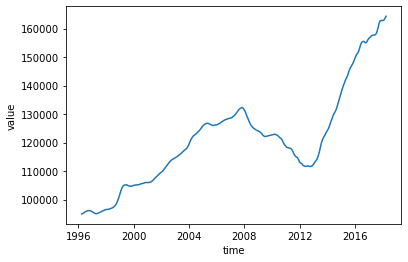

In [13]:
#visualize the data
ax = sns.lineplot(data=test, x=test.index, y='value') 
#ax = test.plot(figsize=(16,6)) 
#ax.set_ylabel('Home Price') 
#plt.xlabel("Date")
#plt.ylabel("Average Price")
#plt.title('Average Home Price - 77084 1996-2018')
#plt.show();

In [14]:
test_recent = test.sort_index().loc['2015':] 
test_recent 

,value
time,
2015-01-01,137700.0
2015-02-01,138900.0
2015-03-01,139900.0
2015-04-01,141000.0
2015-05-01,142100.0
2015-06-01,142900.0
2015-07-01,143900.0
2015-08-01,145200.0
2015-09-01,146200.0


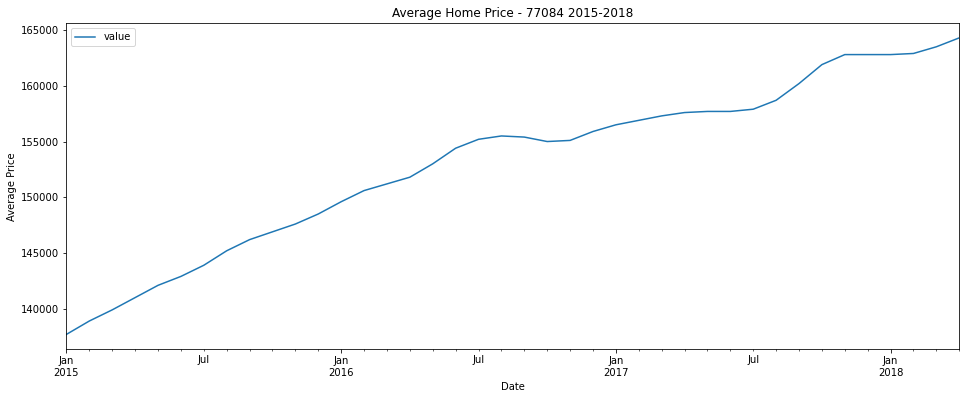

In [15]:
#revisualize data slice
ax = test_recent.plot(figsize=(16,6)) 
ax.set_ylabel('Home Price') 
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.title('Average Home Price - 77084 2015-2018')
plt.show();

In [16]:
#print out price high/low/average/ standard deviation 
print("Min Sale Value", test_recent.min()) 
print("Max Sale Value", test_recent.max()) 
print("Monthly Mean", np.mean(test_recent))
print("Standard Deviation", np.std(test_recent))

Min Sale Value value    137700.0
dtype: float64
Max Sale Value value    164300.0
dtype: float64
Monthly Mean value    153125.0
dtype: float64
Standard Deviation value    7459.482221
dtype: float64


In [17]:
split_77084 = round(test_recent.shape[0]*0.75)
split_77084

30

In [18]:
train_77084 = test_recent[:split_77084]
test_77084 = test_recent[split_77084:]

In [19]:
train_77084

,value
time,
2015-01-01,137700.0
2015-02-01,138900.0
2015-03-01,139900.0
2015-04-01,141000.0
2015-05-01,142100.0
2015-06-01,142900.0
2015-07-01,143900.0
2015-08-01,145200.0
2015-09-01,146200.0


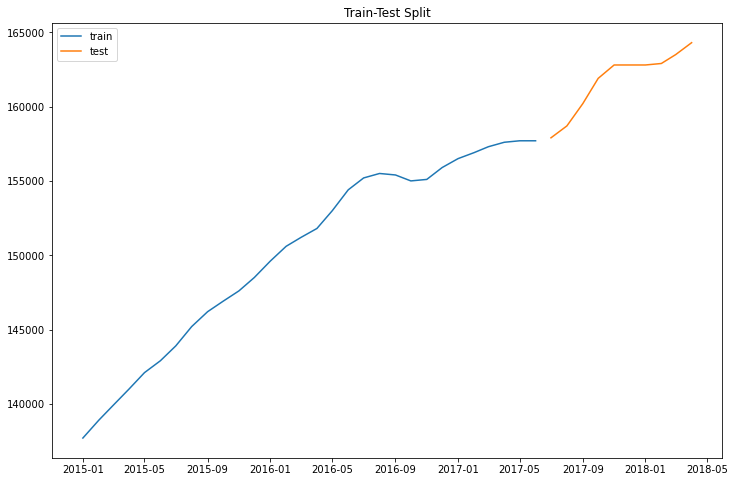

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_77084, label='train')
ax.plot(test_77084, label='test')
ax.set_title('Train-Test Split')
plt.legend();

We then ran a test of our modeling and evaluation procedures on a single zip code -- train-test split, adfuller test for stationarity, finding best parameters using auto-ARIMA, SARIMAX modeling, calculation of MAPE (Mean Absolute Percentage Error), comparing real and predicted values, and testing the forecasting model performance.

In [21]:
adfuller(test_recent)

(-1.7421149721032638,
 0.4095545302605769,
 3,
 36,
 {'1%': -3.626651907578875,
  '5%': -2.9459512825788754,
  '10%': -2.6116707716049383},
 411.4555937050623)

In [25]:
best_arima_nostat(test_recent)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=596.886, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=607.110, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=598.638, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=637.543, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=598.503, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=598.471, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=600.459, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=596.204, Time=0.07 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=597.720, Time=0.17 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=600.194, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=597.580, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=594.254, Time=0.14 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=597.073, Time=0.17 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   40
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -292.938
Date:                Tue, 22 Feb 2022   AIC                            591.876
Time:                        09:36:12   BIC                            596.867
Sample:                    01-01-2015   HQIC                           593.667
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9712      0.016     61.646      0.000       0.940       1.002
ma.L1         -0.9392      0.029    -32.160      0.000      -0.996      -0.882
sigma2      1.975e+05   4.04e+04      4.890      0.0

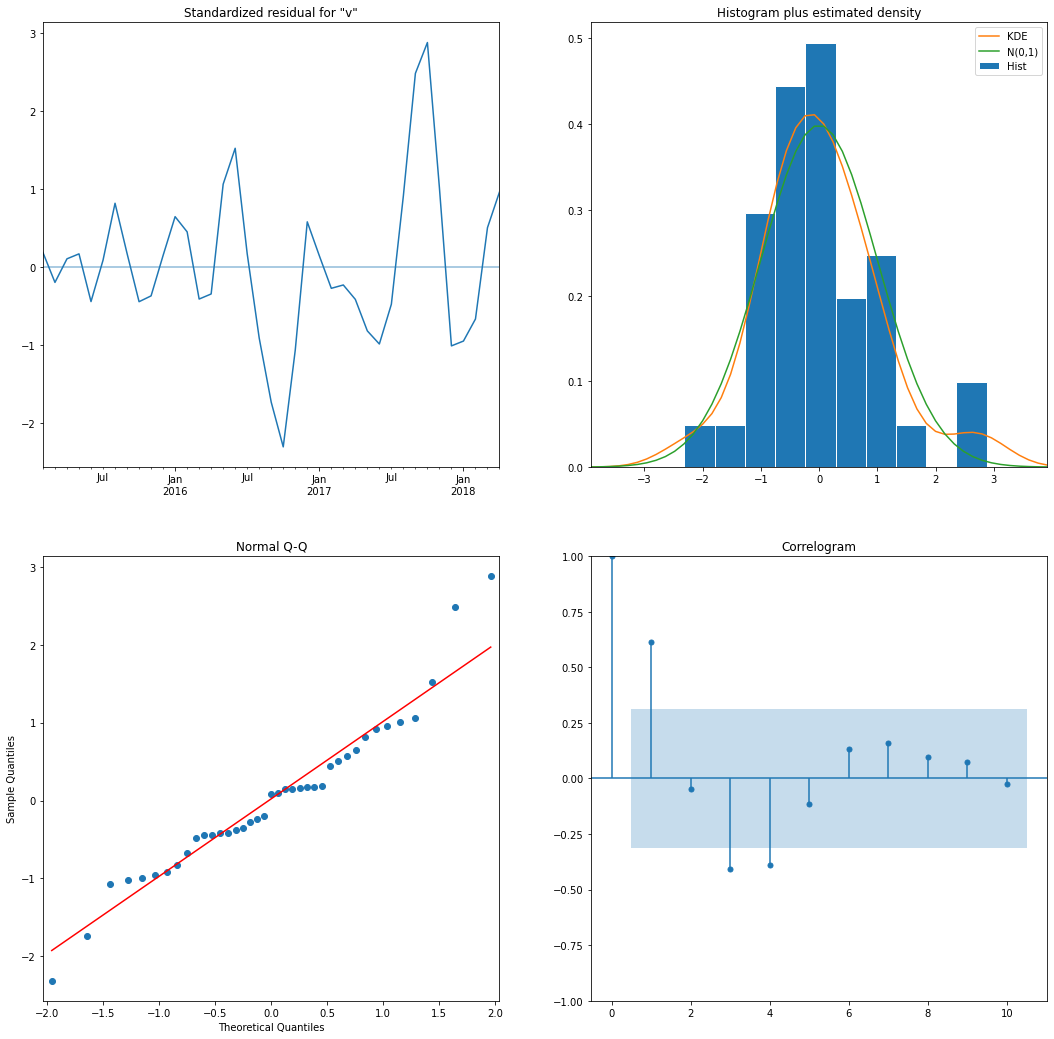

In [26]:
test_model = SARIMAX(test_recent, order=(1,1,1), seasonal_order=(0, 0, 0, 12))

# Fit the model and print results
test_output = test_model.fit()

print(test_output.summary())
test_output.plot_diagnostics(figsize=(18,18))
plt.show()

In [27]:
test_pred = test_output.predict(-40)
MAPE = mape(test_recent,test_pred)
MAPE

0.027070623363421597

<Figure size 1296x1296 with 0 Axes>

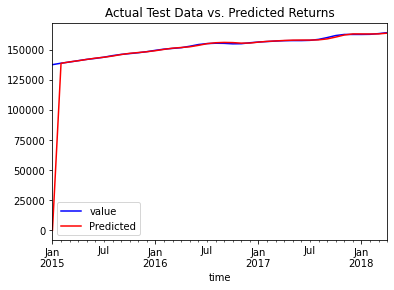

In [28]:
plt.figure(figsize=(18,18))
test_recent.plot(label='Actual',color='b')
test_pred.plot(label='Predicted',color='r')
plt.legend(loc='best')
plt.title('Actual Test Data vs. Predicted Returns')
plt.show();

In [29]:
# Get predictions starting from 04-01-2015 and calculate confidence intervals
pred = test_output.get_prediction(start=pd.to_datetime('2017-08'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower value,upper value
2017-08-01,157423.508987,159166.031023
2017-09-01,158225.226366,159967.711722
2017-10-01,159749.381900,161491.834918
2017-11-01,161478.463005,163220.887512
2017-12-01,162380.000074,164122.399441
2018-01-01,162352.508137,164094.885336
2018-02-01,162326.701470,164069.059121
2018-03-01,162405.684168,164148.024579
2018-04-01,163001.987908,164744.313115


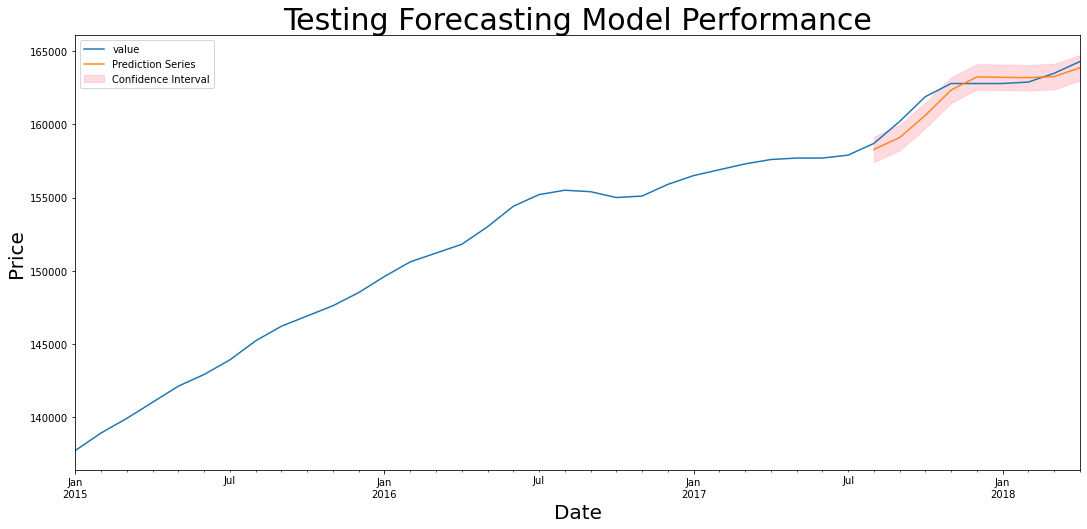

In [30]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 18, 8

# Plot observed values
ax = test_recent.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Prediction Series', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='lightpink', alpha=0.5,label = 'Confidence Interval')

# Set axes labels
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecasting Model Performance',fontsize=30)
plt.legend()

plt.show()

In [31]:
forecast_model = SARIMAX(test_recent, order=(1,1,1), seasonal_order=(0, 0, 0, 12))

# Fit the model and print results
full_output = forecast_model.fit()

print(full_output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9712      0.016     61.646      0.000       0.940       1.002
ma.L1         -0.9392      0.029    -32.160      0.000      -0.996      -0.882
sigma2      1.975e+05   4.04e+04      4.890      0.000    1.18e+05    2.77e+05


In [32]:
forecast = full_output.get_forecast(36)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

,lower,upper,prediction
2018-05-01,163804.923777,165547.235576,164676.079676
2018-06-01,163789.431386,166293.210599,165041.320993
2018-07-01,163838.797377,166953.275229,165396.036303
2018-08-01,163915.105126,167565.952793,165740.528960
2018-09-01,164004.187926,168145.999219,166075.093573
2018-10-01,164099.094406,168700.938117,166400.016262
2018-11-01,164195.913184,169235.236616,166715.574900
2018-12-01,164292.258773,169751.819933,167022.039353
2019-01-01,164386.601828,170252.741591,167319.671709
2019-02-01,164477.931959,170739.521049,167608.726504


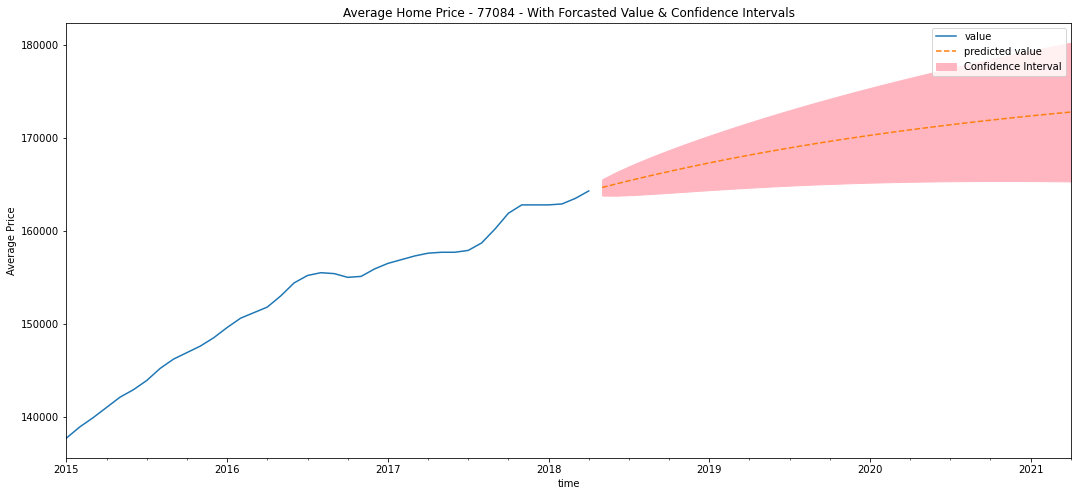

In [33]:
#Plotting our Forecast

fig, ax = plt.subplots()
test_recent.plot(ax=ax,label='Real Values')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='lightpink',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 77084 - With Forcasted Value & Confidence Intervals')
plt.show()

With a successful implmentation of our baseline model and procedure, we created a function which took all of our Houston area zips and ran SARIMAX modeling on each, storing the predictions in a dictionary.

To evaluate our models, we sorted the zip codes by the dollar amount projected increase on the training set. Those zip codes were:

77060 - Aldine area (forecasted increase of ~24% over 3 years)

77015 - Channelview area (forecasted increase of ~23% over 3 years)

77598 - Webster area (forecasted increase of ~23% over 3 years)

77099 - Sugar Land area (forecasted increase of ~22% over 3 years)

77093 - Kingwood area (forecasted increase of ~15% over 3 years)

In [34]:
zip_predictions = {}

#houston_zips is a list of zipcodes in Houston 
for zipcode in houston_zips:
    
    #Melting the time series of our given zipcode
    series = melt_data(houston[houston['Zipcode']== zipcode])
    
    #Only taking data from 2013 onwards to more accurately reflect current market conditions
    recent_series = series['2015':]
    
    # Splitting the last 36 months of our series as a test dataset.
    train_series = recent_series[:'2017-06']
    test_series = recent_series['2017-06':]
    
    #Auto ARIMA model
    auto_model = pm.auto_arima(train_series, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=1,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
   
    # Plug the optimal parameter values for our Training data into a SARIMAX model that fits our entire series.
    ARIMA_MODEL = SARIMAX(recent_series, order= auto_model.order, seasonal_order= auto_model.seasonal_order)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    ## Getting a forecast for the next 36 months after the last absrecorded date on our dataset.
    forecast = output.get_forecast(36)
    prediction = forecast.conf_int()
    prediction['value'] = forecast.predicted_mean
    prediction.columns = ['lower','upper','prediction'] 
    
    #Adding the Zipcode's ROI to the zip_predictions dictionary
    zip_predictions[zipcode] = ((prediction['prediction'][-1])
                                - (series['value'][-1]))/ (series['value'][-1])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=473.646, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=471.922, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=472.111, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=471.040, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=469.400, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=467.254, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=466.528, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=433.342, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=431.540, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=429.773, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=428.263, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=426.335, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=428.260, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=472.994, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, 

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=570.909, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=613.558, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=548.084, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=567.216, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=564.061, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=550.429, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.277 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=543.127, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=564.657, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=547.316, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=540.292, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=610.790, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=608.522, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=564.959, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]            

 ARIMA(1,1,0)(0,0,0)[0]             : AIC=498.620, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=498.818, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=460.041, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=461.904, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=461.961, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=464.041, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.330 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=562.591, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=640.166, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=566.005, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=515.804, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=524.056, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=518.335, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : A

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=486.241, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=495.189, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=507.318, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=506.320, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=476.044, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=486.705, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=487.201, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=515.241, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 1.469 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=533.500, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=534.007, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=534.0

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=552.474, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=589.034, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=609.788, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=577.238, Time=0.02 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=576.678, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=546.551, Time=0.17 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 0.989 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=489.053, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=489.208, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=490.191, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=462.245, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=473.644, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=467.146, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : A

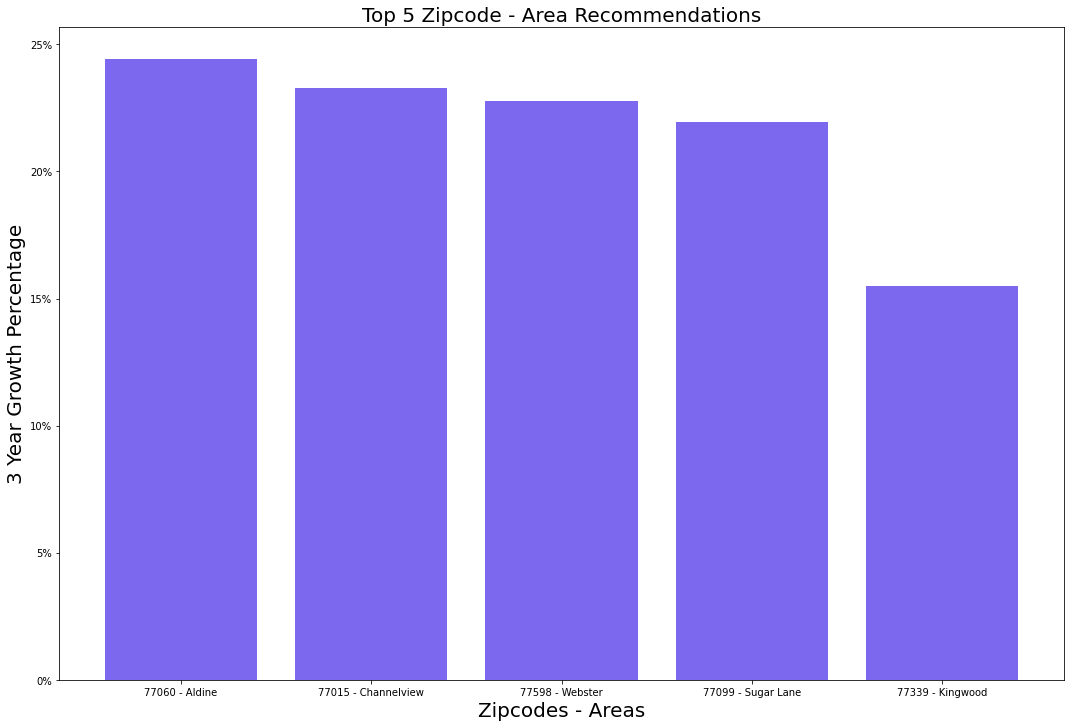

In [35]:
# Sorting our 3 year ROI forecast for zipcodes into descending order
sort_orders = sorted(zip_predictions.items(), key=lambda x: x[1], reverse=True)

sorted_forecast_3yr = {}
for i in sort_orders:
	sorted_forecast_3yr[i[0]] = i[1]

#Selecting only the Top 5 Zips
top_5_zipcodes = list(sorted_forecast_3yr.items())[:5]

fig, ax = plt.subplots(figsize=(18,12))

#x_labels = [top_5_zipcodes[0][0],top_5_zipcodes[1][0],top_5_zipcodes[2][0],
            #top_5_zipcodes[3][0],top_5_zipcodes[4][0]]
            
x_labels = ['77060 - Aldine','77015 - Channelview','77598 - Webster',
            '77099 - Sugar Lane','77339 - Kingwood']
x = [1,2,3,4,5]
y = [top_5_zipcodes[0][1],top_5_zipcodes[1][1],top_5_zipcodes[2][1],
     top_5_zipcodes[3][1],top_5_zipcodes[4][1]]

ax.bar(x, y, color='mediumslateblue')
remaining_zipcodes = list(sorted_forecast_3yr.items())[5:]
median_ROI_other_zips = remaining_zipcodes[5][1]
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_yticks([(a/100) for a in list(range(0,30,5))])
ax.set_yticklabels([str(a)+'%' for a in list(range(0,30,5))])
ax.set_title('Top 5 Zipcode - Area Recommendations', fontsize=20)
ax.set_ylabel('3 Year Growth Percentage', fontsize=20)
ax.set_xlabel('Zipcodes - Areas',fontsize=20);

In [36]:
print(f'The Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[:1][0][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[:1][0][1])*100,2)}%')

The Highest Growing Zipcode: 77060 is expected to grow by 24.44%


In [37]:
print(f'The Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[0][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[0][1])*100,2)}%')
print(f'The Second Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[1][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[1][1])*100,2)}%')
print(f'The Third Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[2][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[2][1])*100,2)}%')
print(f'The Fourth Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[3][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[3][1])*100,2)}%')
print(f'The Fifth Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[4][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[4][1])*100,2)}%')

The Highest Growing Zipcode: 77060 is expected to grow by 24.44%
The Second Highest Growing Zipcode: 77015 is expected to grow by 23.29%
The Third Highest Growing Zipcode: 77598 is expected to grow by 22.76%
The Fourth Highest Growing Zipcode: 77099 is expected to grow by 21.96%
The Fifth Highest Growing Zipcode: 77339 is expected to grow by 15.49%


In [38]:
recommended_zips = pd.DataFrame([a for a in sorted_forecast_3yr.keys()][:5])
recommended_zips['latitude'] = [29.9389, 29.7690, 29.5451, 29.6451, 30.0442]
recommended_zips['longitude'] = [-95.3992, -95.1745, -95.1380, -95.5250, -95.2162]
recommended_zips.columns = ['ZipCode','Latitude','Longitude']

m = folium.Map(
    location=[29.7604,-95.3698],
    width='100%',
    length='50%',
    zoom_start=10
)

for a in list(range(len(recommended_zips))):
    
    folium.Circle(
    radius=4000,
    location=[recommended_zips[['Latitude','Longitude']].iloc[a][0],recommended_zips[['Latitude','Longitude']].iloc[a][1]],
    popup="The Waterfront",
    color="crimson",
    fill=True,
    ).add_to(m);

m

#### 77060

In [39]:
df_77060 = houston.groupby('Zipcode').get_group(77060)  
df_77060

,Zipcode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1802,77060,57700.0,57800.0,57800.0,58000.0,58100.0,58200.0,58300.0,58400.0,58600.0,...,118500,118900,119900,121100,121500,121500,121500,121700,122400,122900


In [40]:
melted_77060 = melt_data(df_77060) 

In [41]:
ts_77060 = melted_77060.sort_index().loc['2015':] 

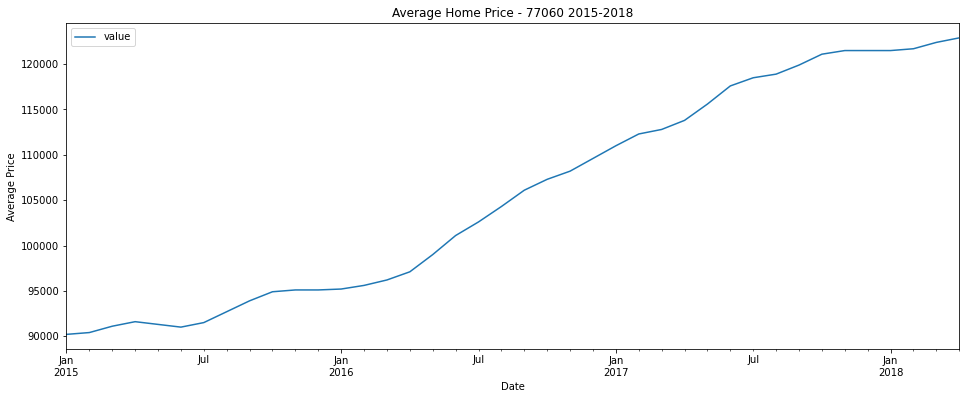

In [42]:
ax = ts_77060.plot(figsize=(16,6)) 
ax.set_ylabel('Home Price') 
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.title('Average Home Price - 77060 2015-2018')
plt.show();

In [43]:
split_77060 = round(ts_77060.shape[0]*0.75)
split_77060

30

In [44]:
train_77060 = test_recent[:split_77060]
test_77060 = test_recent[split_77060:]

In [45]:
adfuller(ts_77060)

(-0.93446458577728,
 0.7764110111416421,
 3,
 36,
 {'1%': -3.626651907578875,
  '5%': -2.9459512825788754,
  '10%': -2.6116707716049383},
 433.9758564310747)

In [46]:
best_arima_nostat(ts_77060)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=619.104, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=621.310, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=621.776, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=655.804, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=619.724, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=619.621, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=621.603, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=632.194, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=621.249, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=619.608, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 1.154 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   40
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -307.953
Date:                Tue, 22 Feb 2022   AIC                            621.907
Time:                        09:39:53   BIC                            626.897
Sample:                    01-01-2015   HQIC                           623.697
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.007    134.750      0.000       0.985       1.015
ma.L1         -0.9990      0.229     -4.363      0.000      -1.448      -0.550
sigma2      4.188e+05   3.58e-07   1.17e+12      0.0

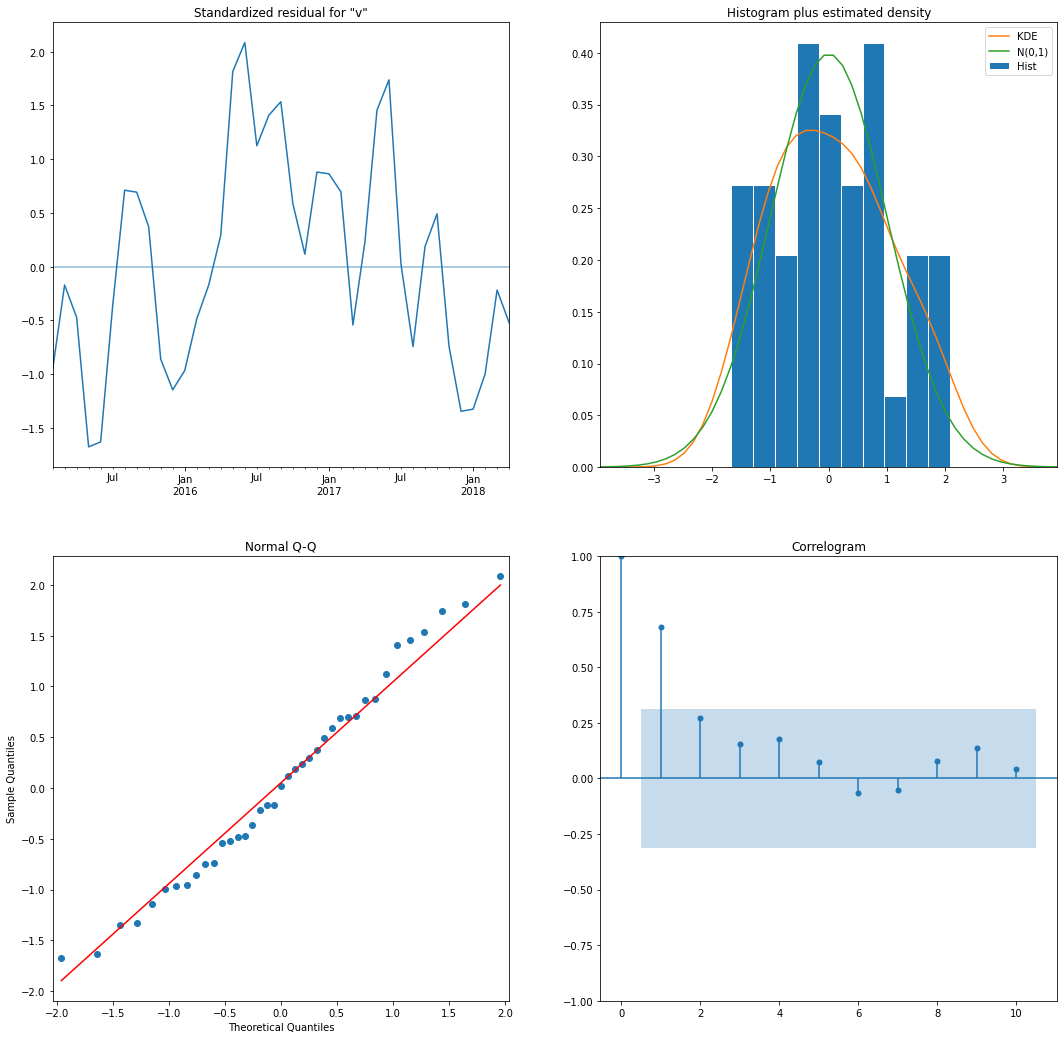

In [47]:
model_77060 = SARIMAX(ts_77060, order=(1,1,1), seasonal_order=(0, 0, 0, 12))

# Fit the model and print results
output_77060 = model_77060.fit()

print(output_77060.summary())
output_77060.plot_diagnostics(figsize=(18,18))
plt.show();

In [48]:
pred_77060 = output_77060.predict(-40)
MAPE = mape(ts_77060,pred_77060)
MAPE

0.030116145014736296

<Figure size 1296x1296 with 0 Axes>

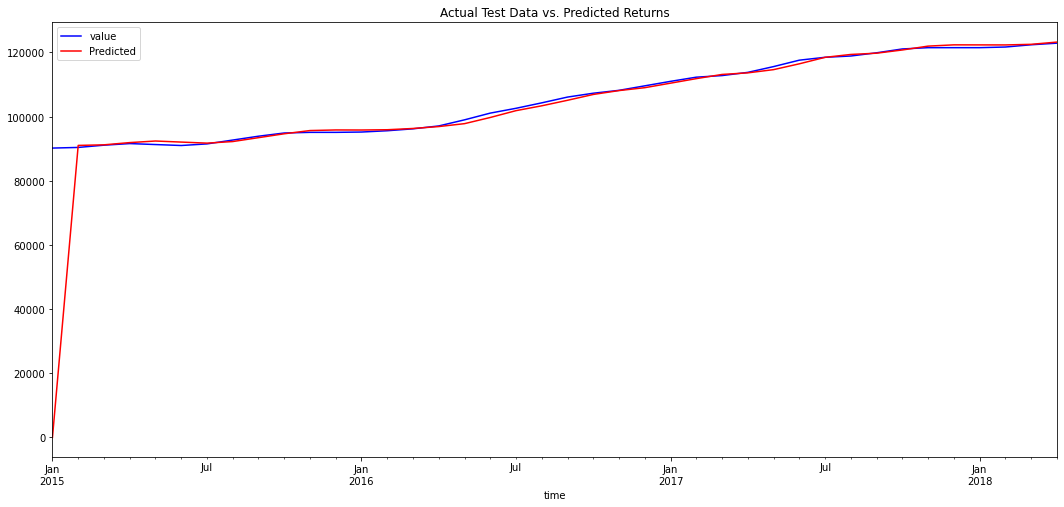

In [49]:
plt.figure(figsize=(18,18))
ts_77060.plot(label='Actual',color='b')
pred_77060.plot(label='Predicted',color='r')
plt.legend(loc='best')
plt.title('Actual Test Data vs. Predicted Returns')
plt.show();

In [50]:
gpred_77060 = output_77060.get_prediction(start=pd.to_datetime('2017-06'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf_77060 = gpred_77060.conf_int()
pred_conf_77060

,lower value,upper value
2017-06-01,115187.836132,117744.474240
2017-07-01,117206.579374,119762.874591
2017-08-01,118106.976982,120662.940334
2017-09-01,118499.425380,121055.067373
2017-10-01,119501.484579,122056.815227
2017-11-01,120706.557307,123261.586165
2017-12-01,121099.353986,123654.090174
2018-01-01,121086.394536,123640.846770
2018-02-01,121073.815847,123627.992458
2018-03-01,121264.500451,123818.409410


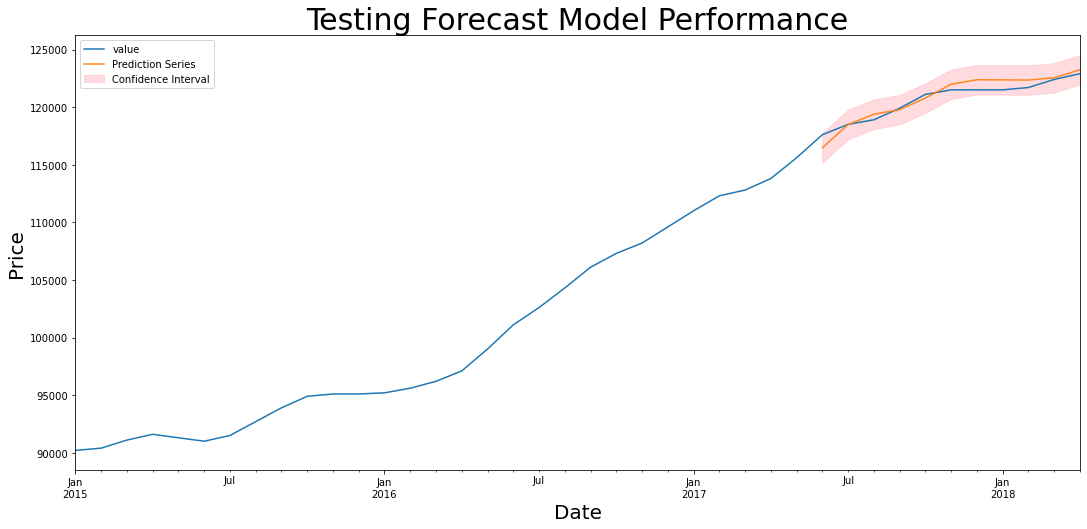

In [51]:
rcParams['figure.figsize'] = 18, 8

# Plot observed values
ax = ts_77060.plot(label='observed')

# Plot predicted values
gpred_77060.predicted_mean.plot(ax=ax, label='Prediction Series', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf_77060.index,
                pred_conf_77060.iloc[:, 0],
                pred_conf_77060.iloc[:, 1], color='lightpink', alpha=0.5,label = 'Confidence Interval')

# Set axes labels
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecast Model Performance',fontsize=30)
plt.legend()

plt.show();

In [52]:
forecast_model_77060 = SARIMAX(ts_77060, order=(1,1,1), seasonal_order=(0, 0, 0, 12))

# Fit the model and print results
full_output_77060 = forecast_model_77060.fit()

print(full_output_77060.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.007    134.750      0.000       0.985       1.015
ma.L1         -0.9990      0.229     -4.363      0.000      -1.448      -0.550
sigma2      4.188e+05   3.58e-07   1.17e+12      0.000    4.19e+05    4.19e+05


In [53]:
forecast_77060 = full_output_77060.get_forecast(36)
future_prediction_77060 = forecast_77060.conf_int()
future_prediction_77060['value'] = forecast_77060.predicted_mean
future_prediction_77060.columns = ['lower','upper','prediction'] 
future_prediction_77060

,lower,upper,prediction
2018-05-01,122457.925970,125011.322197,123734.624083
2018-06-01,122751.211540,126387.257150,124569.234345
2018-07-01,123162.012852,127645.648718,125403.830785
2018-08-01,123632.347143,128844.479664,126238.413404
2018-09-01,124139.944671,130006.019731,127072.982201
2018-10-01,124673.479023,131141.595332,127907.537177
2018-11-01,125226.278077,132257.878590,128742.078333
2018-12-01,125794.031394,133359.179943,129576.605669
2019-01-01,126373.770629,134448.467738,130411.119184
2019-02-01,126963.353337,135527.884421,131245.618879


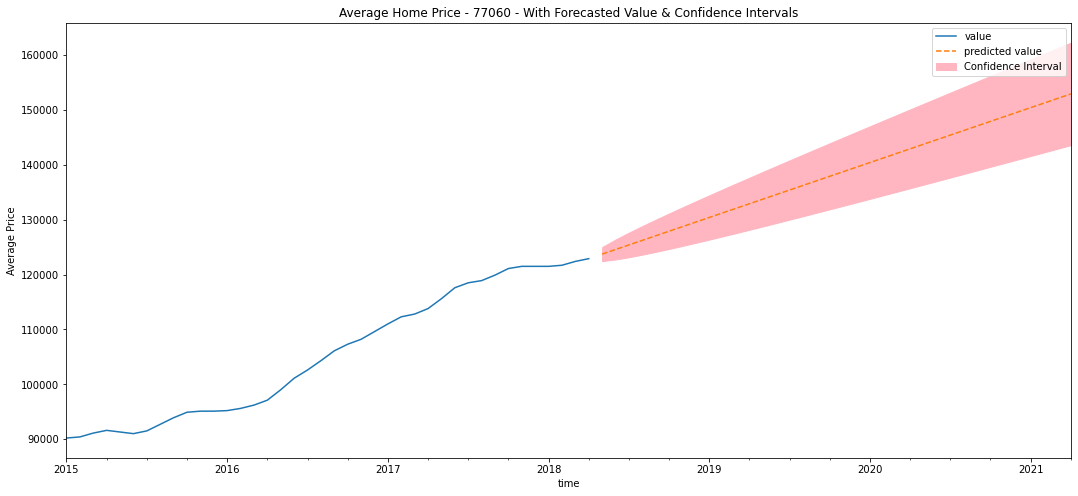

In [54]:
fig, ax = plt.subplots()
ts_77060.plot(ax=ax,label='Real Values')


future_prediction_77060['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction_77060.index, y1= future_prediction_77060['lower'], 
                y2= future_prediction_77060['upper'],color='lightpink',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 77060 - With Forecasted Value & Confidence Intervals')
plt.show()

#### 77339

In [55]:
df_77339 = houston.groupby('Zipcode').get_group(77339)  
df_77339

,Zipcode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1173,77339,119300.0,119200.0,119000.0,118800.0,118700.0,118400.0,118200.0,118000.0,117800.0,...,197600,198500,199800,200900,201400,201900,202500,203600,205700,207600


In [56]:
melted_77339 = melt_data(df_77339)

In [57]:
ts_77339 = melted_77339.sort_index().loc['2015':] 

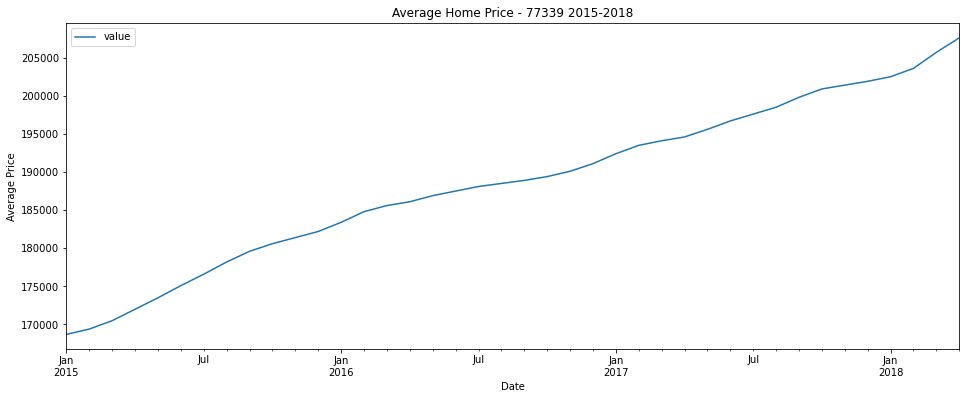

In [58]:
ax = ts_77339.plot(figsize=(16,6)) 
ax.set_ylabel('Home Price') 
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.title('Average Home Price - 77339 2015-2018')
plt.show();

In [59]:
split_77339 = round(ts_77339.shape[0]*0.75)

In [60]:
train_77339 = test_recent[:split_77339]
test_77339= test_recent[split_77339:]

In [61]:
adfuller(ts_77339)

(-0.8179274291641773,
 0.8137992192692995,
 2,
 37,
 {'1%': -3.6209175221605827,
  '5%': -2.9435394610388332,
  '10%': -2.6104002410518627},
 413.74427257113786)

In [62]:
best_arima_nostat(ts_77339)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=586.770, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=590.607, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=590.944, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=657.793, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=588.697, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=588.690, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=590.689, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=588.688, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=589.051, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=590.244, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 1.052 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   40
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -291.809
Date:                Tue, 22 Feb 2022   AIC                            589.619
Time:                        09:41:21   BIC                            594.610
Sample:                    01-01-2015   HQIC                           591.409
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.005    219.971      0.000       0.991       1.009
ma.L1         -0.9951      0.036    -27.524      0.000      -1.066      -0.924
sigma2      1.817e+05   1.83e-08   9.93e+12      0.0

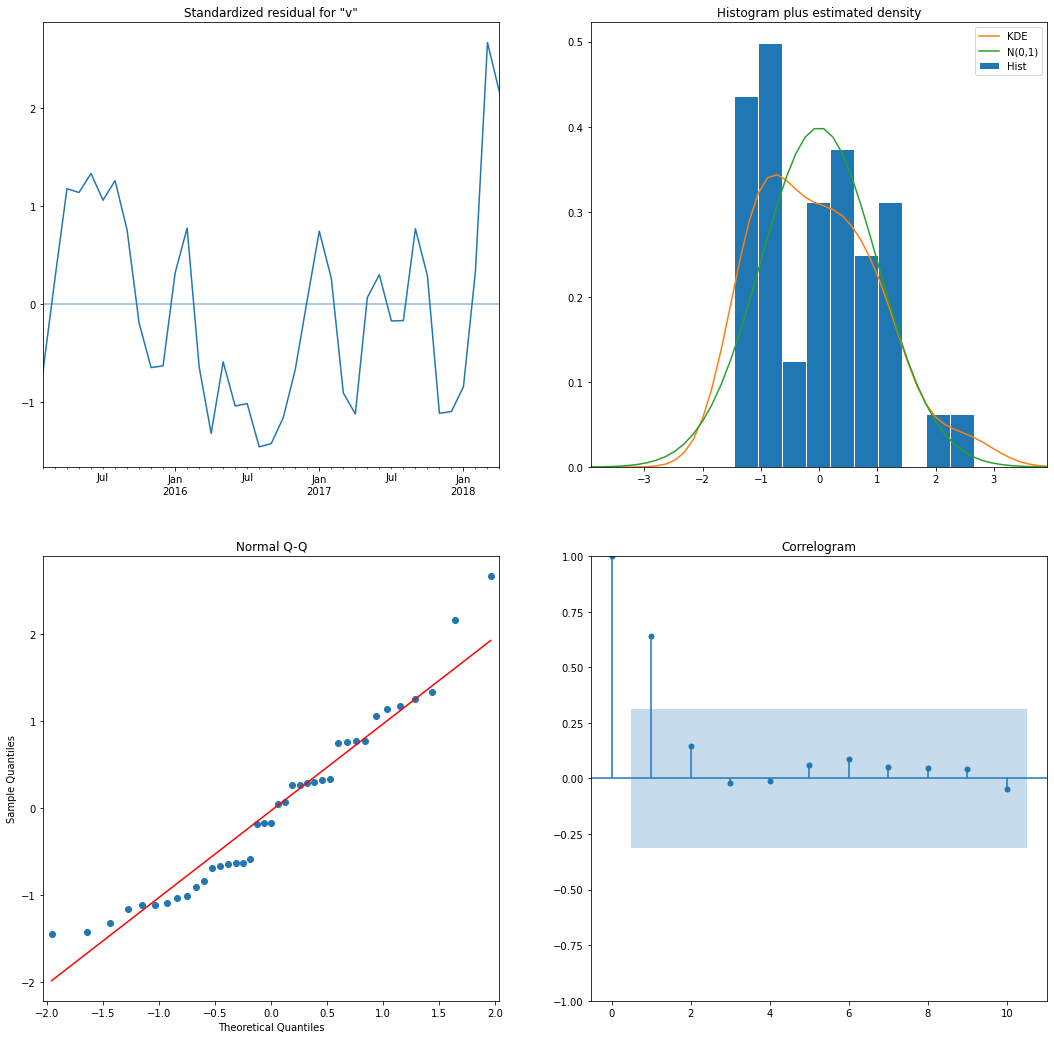

In [63]:
model_77339 = SARIMAX(ts_77339, order=(1,1,1), seasonal_order=(0, 0, 0, 12))

# Fit the model and print results
output_77339 = model_77339.fit()

print(output_77339.summary())
output_77339.plot_diagnostics(figsize=(18,18))
plt.show();

In [64]:
pred_77339 = output_77339.predict(-40)
MAPE = mape(ts_77339, pred_77339)
MAPE

0.02685300820503168

<Figure size 1296x1296 with 0 Axes>

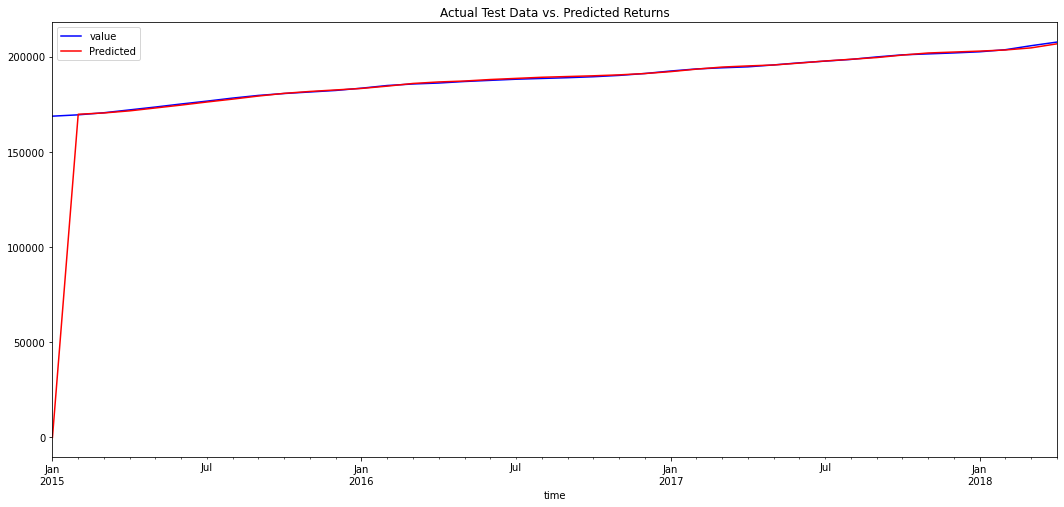

In [65]:
plt.figure(figsize=(18,18))
ts_77339.plot(label='Actual',color='b')
pred_77339.plot(label='Predicted',color='r')
plt.legend(loc='best')
plt.title('Actual Test Data vs. Predicted Returns')
plt.show();

In [66]:
gpred_77339 = output_77339.get_prediction(start=pd.to_datetime('2017-06'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf_77339 = gpred_77339.conf_int()
pred_conf_77339

,lower value,upper value
2017-06-01,195730.528840,197413.301269
2017-07-01,196832.713050,198515.212060
2017-08-01,197731.204108,199413.439690
2017-09-01,198629.742794,200311.724416
2017-10-01,199935.304451,201617.041090
2017-11-01,201037.240914,202718.741092
2017-12-01,201528.978663,203210.250474
2018-01-01,202020.981993,203702.033134
2018-02-01,202614.873708,204295.711505
2018-03-01,203717.007845,205397.639272


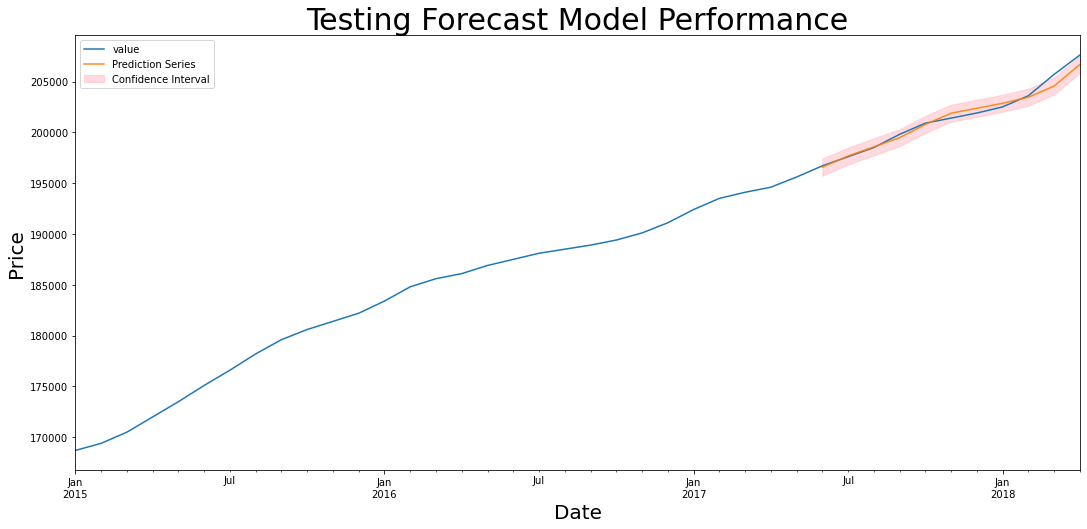

In [67]:
rcParams['figure.figsize'] = 18, 8

# Plot observed values
ax = ts_77339.plot(label='observed')

# Plot predicted values
gpred_77339.predicted_mean.plot(ax=ax, label='Prediction Series', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf_77339.index,
                pred_conf_77339.iloc[:, 0],
                pred_conf_77339.iloc[:, 1], color='lightpink', alpha=0.5,label = 'Confidence Interval')

# Set axes labels
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecast Model Performance',fontsize=30)
plt.legend()

plt.show();

In [68]:
forecast_model_77339 = SARIMAX(ts_77339, order=(1,1,1), seasonal_order=(0, 0, 0, 12))

# Fit the model and print results
full_output_77339 = forecast_model_77339.fit()

print(full_output_77339.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.005    219.971      0.000       0.991       1.009
ma.L1         -0.9951      0.036    -27.524      0.000      -1.066      -0.924
sigma2      1.817e+05   1.83e-08   9.93e+12      0.000    1.82e+05    1.82e+05


In [69]:
forecast_77339 = full_output_77339.get_forecast(36)
future_prediction_77339 = forecast_77339.conf_int()
future_prediction_77339['value'] = forecast_77339.predicted_mean
future_prediction_77339.columns = ['lower','upper','prediction'] 
future_prediction_77339

,lower,upper,prediction
2018-05-01,207749.184072,209429.422401,208589.303237
2018-06-01,208381.067192,210775.524641,209578.295916
2018-07-01,209089.587648,212044.368626,210566.978137
2018-08-01,209836.690128,213274.009862,211555.349995
2018-09-01,210607.772866,214479.050311,212543.411589
2018-10-01,211395.416632,215666.909398,213531.163015
2018-11-01,212195.255248,216841.953495,214518.604372
2018-12-01,213004.470832,218007.000680,215505.735756
2019-01-01,213821.124848,219163.989682,216492.557265
2019-02-01,214643.819577,220314.318415,217479.068996


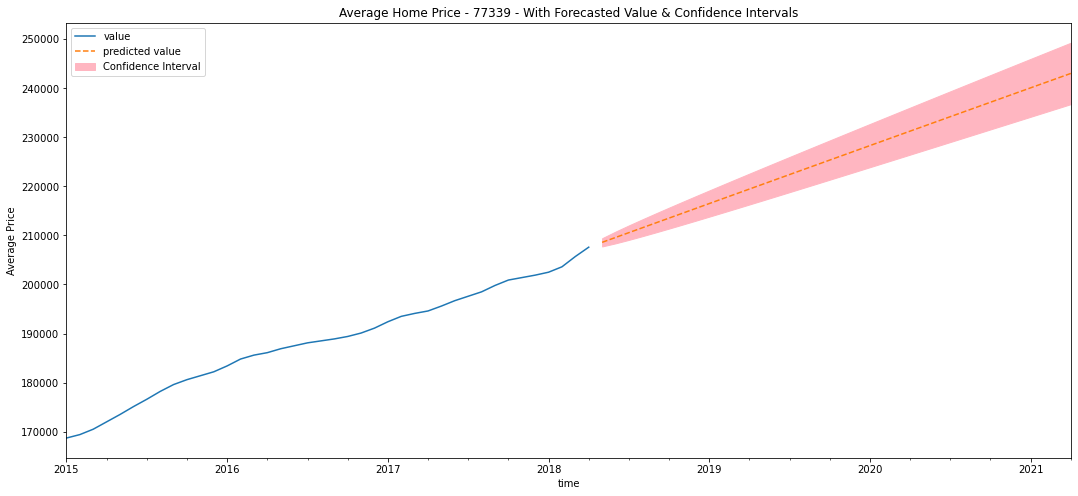

In [70]:
fig, ax = plt.subplots()
ts_77339.plot(ax=ax,label='Real Values')


future_prediction_77339['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction_77339.index, y1= future_prediction_77339['lower'], 
                y2= future_prediction_77339['upper'],color='lightpink',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 77339 - With Forecasted Value & Confidence Intervals')
plt.show()

#### 77598

In [71]:
df_77598 = houston.groupby('Zipcode').get_group(77598)  
df_77598

,Zipcode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
3065,77598,89200.0,89200.0,89300.0,89400.0,89400.0,89400.0,89500.0,89500.0,89500.0,...,168900,169800,170900,172200,172900,173800,174900,176300,177800,178900


In [72]:
melted_77598 = melt_data(df_77598)

In [73]:
ts_77598 = melted_77598.sort_index().loc['2015':] 

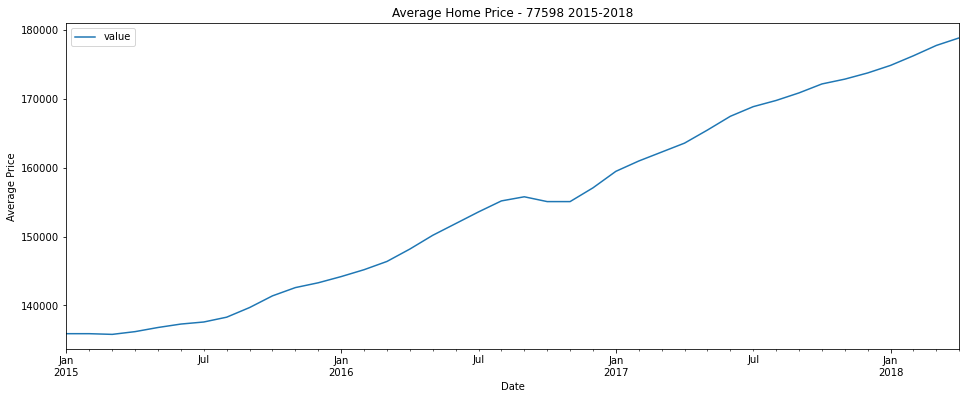

In [74]:
ax = ts_77598.plot(figsize=(16,6)) 
ax.set_ylabel('Home Price') 
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.title('Average Home Price - 77598 2015-2018')
plt.show();

In [75]:
split_77598 = round(ts_77598.shape[0]*0.75)

In [76]:
train_77598 = test_recent[:split_77598]
test_77598 = test_recent[split_77598:]

In [77]:
adfuller(ts_77598)

(0.44839847020107115,
 0.9832173862825715,
 4,
 35,
 {'1%': -3.6327426647230316,
  '5%': -2.9485102040816327,
  '10%': -2.6130173469387756},
 434.2296435107514)

In [78]:
best_arima_nostat(ts_77598)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=621.121, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=639.412, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=623.451, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=671.055, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=622.978, Time=0.10 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=622.975, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=624.975, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=621.426, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=621.620, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=617.477, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=618.891, Time=0.19 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=617.462, Time=0.24 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=617.274, Time=0.51 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True)

                                        SARIMAX Results                                        
Dep. Variable:                                   value   No. Observations:                   40
Model:             SARIMAX(2, 1, 1)x(0, 0, [1, 2], 12)   Log Likelihood                -313.787
Date:                                 Tue, 22 Feb 2022   AIC                            639.574
Time:                                         09:42:56   BIC                            649.555
Sample:                                     01-01-2015   HQIC                           643.155
                                          - 04-01-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9764      0.014     71.201      0.000       0.950       1

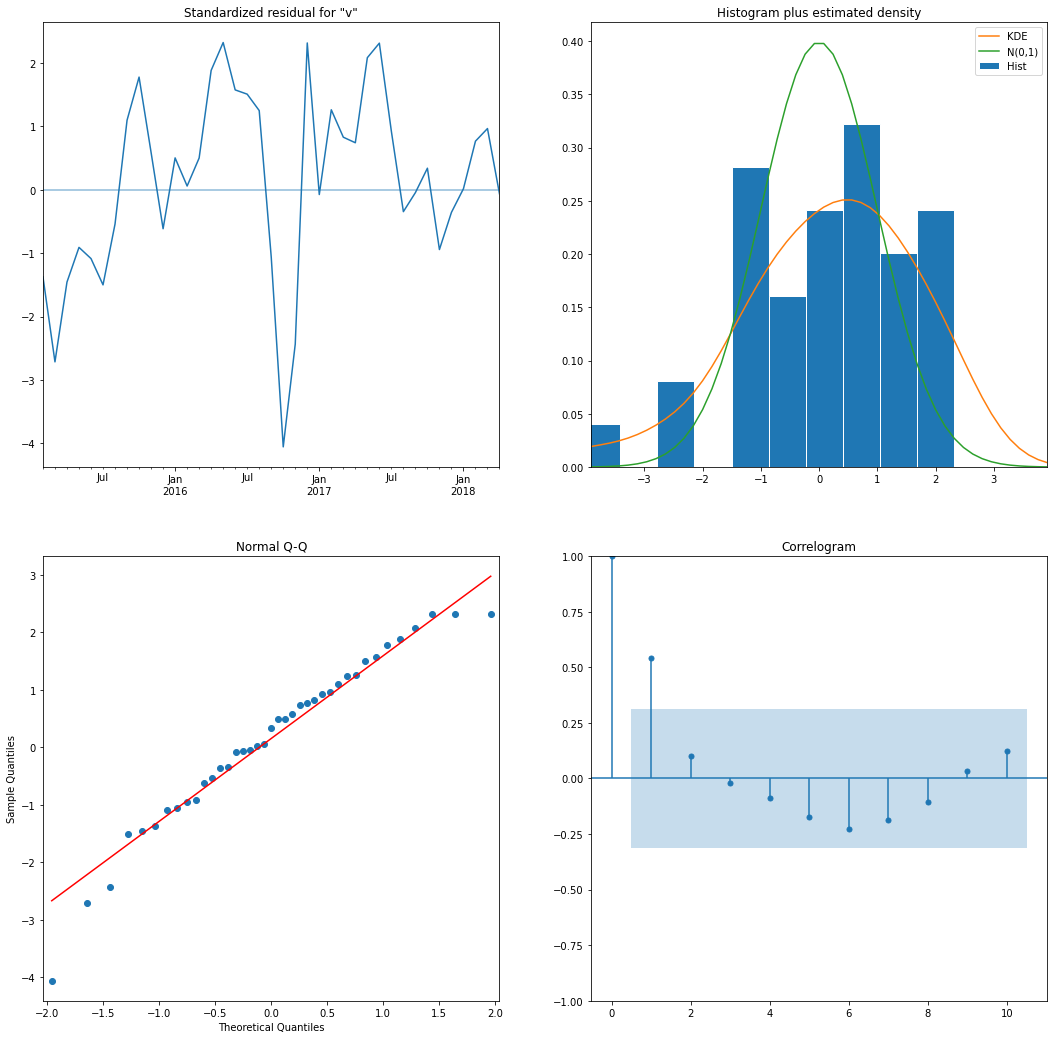

In [79]:
model_77598 = SARIMAX(ts_77598, order=(2,1,1), seasonal_order=(0, 0, 2, 12))

# Fit the model and print results
output_77598 = model_77598.fit()

print(output_77598.summary())
output_77598.plot_diagnostics(figsize=(18,18))
plt.show();

In [80]:
pred_77598 = output_77598.predict(-40)
MAPE = mape(ts_77598,pred_77598)
MAPE

0.028255543315786485

<Figure size 1296x1296 with 0 Axes>

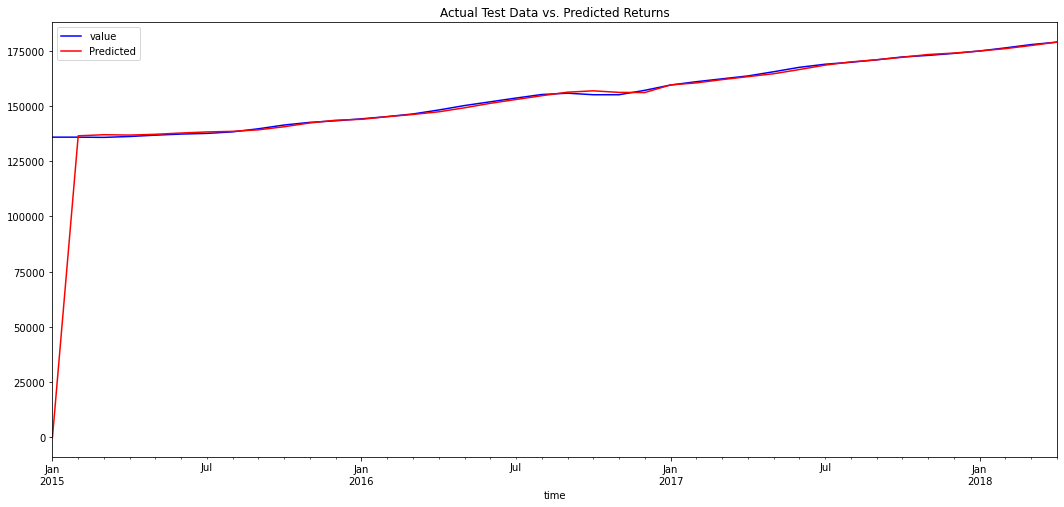

In [81]:
plt.figure(figsize=(18,18))
ts_77598.plot(label='Actual',color='b')
pred_77598.plot(label='Predicted',color='r')
plt.legend(loc='best')
plt.title('Actual Test Data vs. Predicted Returns')
plt.show();

In [82]:
gpred_77598 = output_77598.get_prediction(start=pd.to_datetime('2017-06'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf_77598 = gpred_77598.conf_int()
pred_conf_77598

,lower value,upper value
2017-06-01,165646.541451,167346.892291
2017-07-01,167649.766151,169349.809599
2017-08-01,169099.611289,170799.358771
2017-09-01,170069.585361,171769.047676
2017-10-01,171202.824779,172902.012144
2017-11-01,172458.968820,174157.890911
2017-12-01,173105.072182,174803.738345
2018-01-01,174043.347464,175741.758916
2018-02-01,175118.667192,176816.795196
2018-03-01,176532.629653,178230.527024


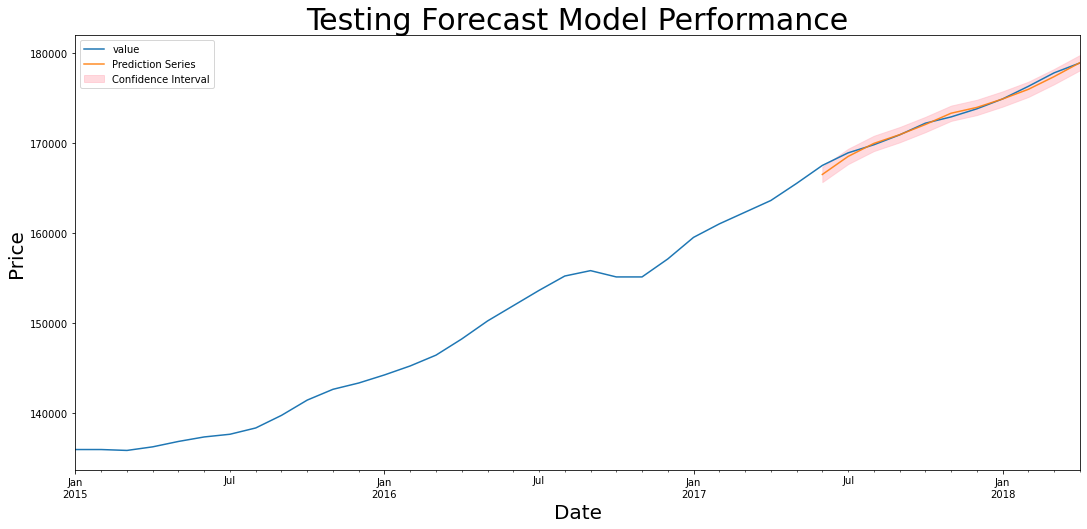

In [83]:
rcParams['figure.figsize'] = 18, 8

# Plot observed values
ax = ts_77598.plot(label='observed')

# Plot predicted values
gpred_77598.predicted_mean.plot(ax=ax, label='Prediction Series', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf_77598.index,
                pred_conf_77598.iloc[:, 0],
                pred_conf_77598.iloc[:, 1], color='lightpink', alpha=0.5,label = 'Confidence Interval')

# Set axes labels
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecast Model Performance',fontsize=30)
plt.legend()

plt.show();

In [84]:
forecast_model_77598 = SARIMAX(ts_77598, order=(2,1,1), seasonal_order=(0, 0, 2, 12))

# Fit the model and print results
full_output_77598 = forecast_model_77598.fit()

print(full_output_77598.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9764      0.014     71.201      0.000       0.950       1.003
ar.L2          0.0235      0.014      1.674      0.094      -0.004       0.051
ma.L1         -0.9994      0.112     -8.927      0.000      -1.219      -0.780
ma.S.L12      -0.0127      0.037     -0.347      0.728      -0.084       0.059
ma.S.L24       0.0684      0.120      0.570      0.569      -0.167       0.304
sigma2      1.847e+05   6.21e-07   2.97e+11      0.000    1.85e+05    1.85e+05


In [85]:
forecast_77598 = full_output_77598.get_forecast(36)
future_prediction_77598 = forecast_77598.conf_int()
future_prediction_77598['value'] = forecast_77598.predicted_mean
future_prediction_77598.columns = ['lower','upper','prediction'] 
future_prediction_77598

,lower,upper,prediction
2018-05-01,179195.549493,180893.009474,180044.279484
2018-06-01,179970.334540,182361.330557,181165.832548
2018-07-01,180824.836887,183764.516849,182294.676868
2018-08-01,181716.990903,185130.602061,183423.796482
2018-09-01,182563.401600,186403.975514,184483.688557
2018-10-01,183335.862914,187570.661359,185453.262137
2018-11-01,184174.715609,188779.416681,186477.066145
2018-12-01,185157.765985,190113.496056,187635.631021
2019-01-01,186073.911103,191365.601153,188719.756128
2019-02-01,187033.649328,192649.204942,189841.427135


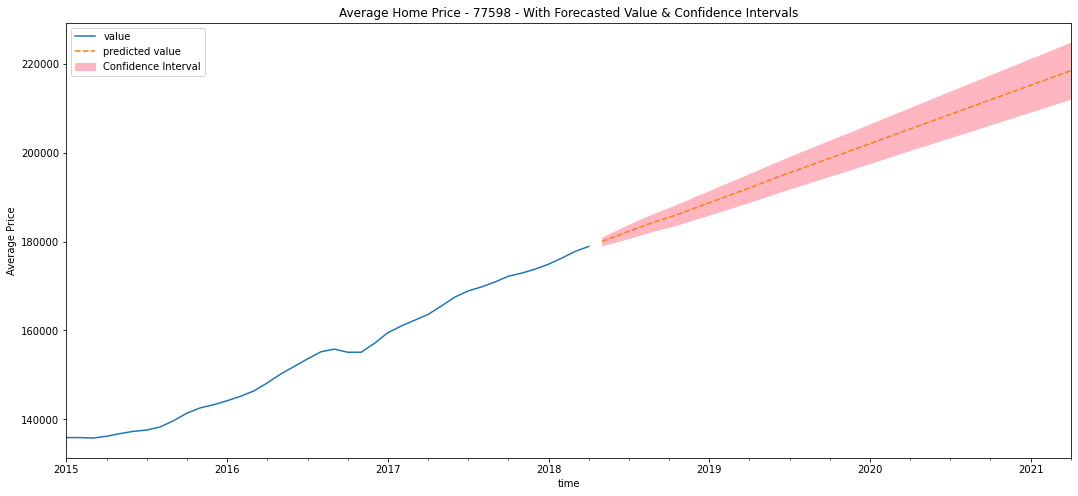

In [86]:
fig, ax = plt.subplots()
ts_77598.plot(ax=ax,label='Real Values')


future_prediction_77598['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction_77598.index, y1= future_prediction_77598['lower'], 
                y2= future_prediction_77598['upper'],color='lightpink',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 77598 - With Forecasted Value & Confidence Intervals')
plt.show()

#### 77015

In [87]:
df_77015 = houston.groupby('Zipcode').get_group(77015)  
df_77015

,Zipcode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1028,77015,66100.0,66100.0,66200.0,66300.0,66500.0,66500.0,66600.0,66700.0,66800.0,...,125500,125900,126200,127100,128500,129700,130400,131400,133000,134100


In [88]:
melted_77015 = melt_data(df_77015)

In [89]:
ts_77015 = melted_77015.sort_index().loc['2015':] 

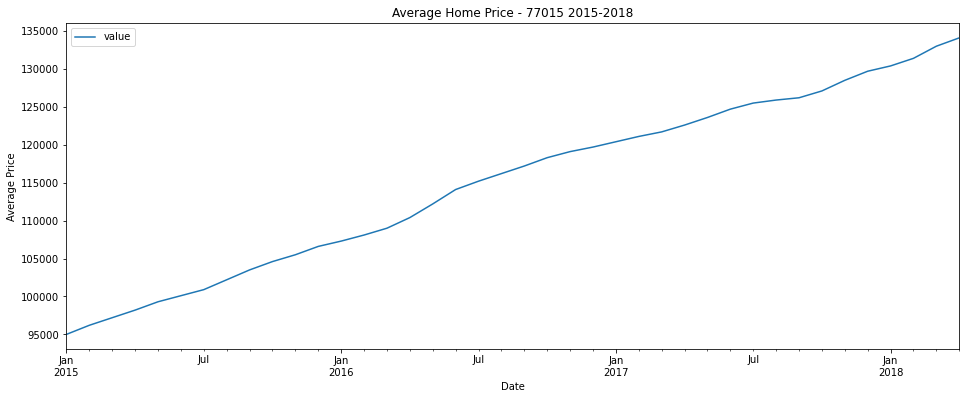

In [90]:
ax = ts_77015.plot(figsize=(16,6)) 
ax.set_ylabel('Home Price') 
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.title('Average Home Price - 77015 2015-2018')
plt.show();

In [91]:
split_77015 = round(ts_77015.shape[0]*0.75)

In [92]:
train_77015 = test_recent[:split_77015]
test_77015 = test_recent[split_77015:]

In [93]:
adfuller(ts_77015)

(-1.7524907425922072,
 0.4042905173722655,
 5,
 34,
 {'1%': -3.639224104416853,
  '5%': -2.9512301791166293,
  '10%': -2.614446989619377},
 413.7567113273815)

In [94]:
best_arima_nostat(ts_77015)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=570.230, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=566.847, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=567.937, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=567.832, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=655.678, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=568.252, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=567.786, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=569.727, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=566.909, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=567.042, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=569.194, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 1.026 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   40
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -281.894
Date:                Tue, 22 Feb 2022   AIC                            569.787
Time:                        09:44:14   BIC                            574.778
Sample:                    01-01-2015   HQIC                           571.578
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9961      0.005    193.606      0.000       0.986       1.006
ma.L1         -0.9700      0.023    -42.167      0.000      -1.015      -0.925
sigma2      1.108e+05   3.38e-09   3.28e+13      0.0

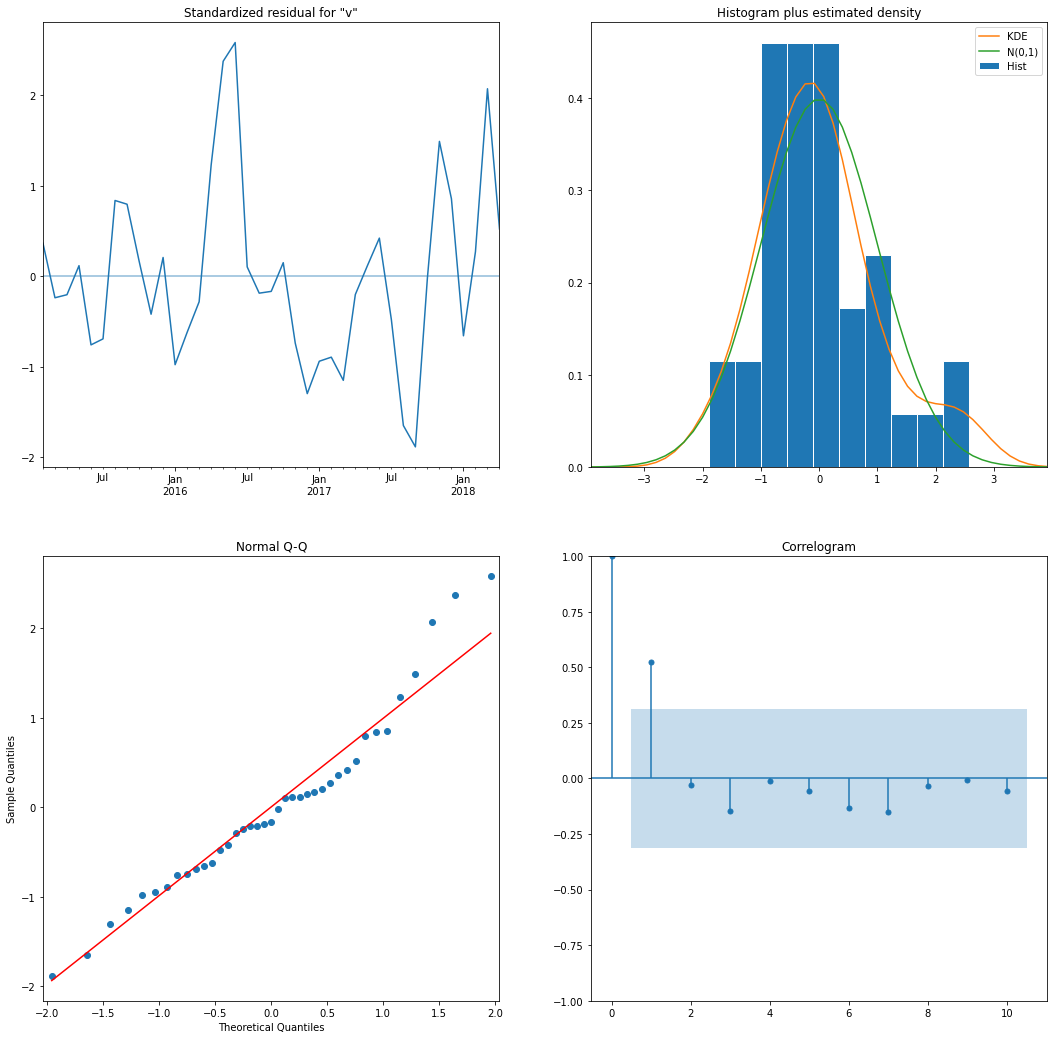

In [95]:
model_77015 = SARIMAX(ts_77015, order=(1,1,1), seasonal_order=(0, 0, 0, 12))

# Fit the model and print results
output_77015 = model_77015.fit()

print(output_77015.summary())
output_77015.plot_diagnostics(figsize=(18,18))
plt.show();

In [96]:
pred_77015 = output_77015.predict(-40)
MAPE = mape(ts_77015,pred_77015)
MAPE

0.027095482912523984

<Figure size 1296x1296 with 0 Axes>

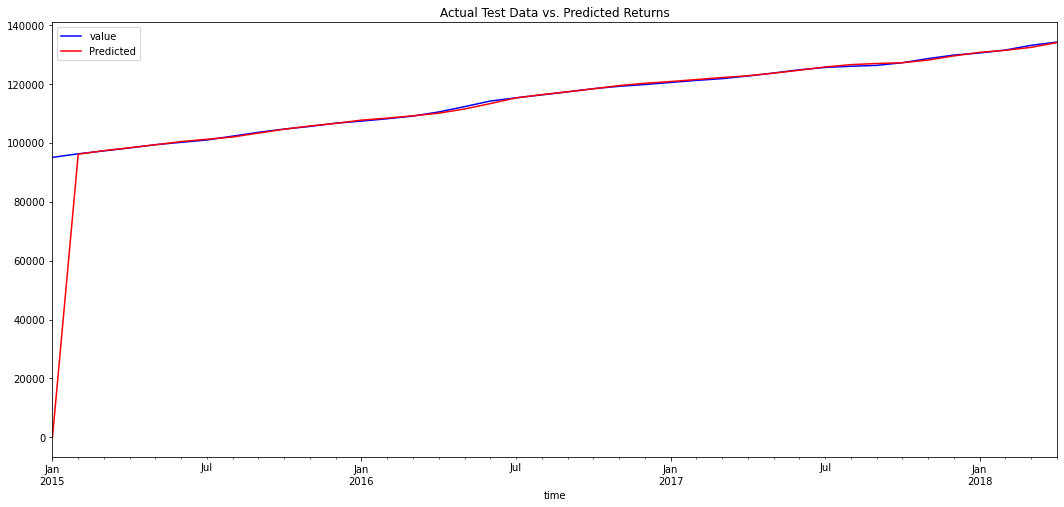

In [97]:
plt.figure(figsize=(18,18))
ts_77015.plot(label='Actual',color='b')
pred_77015.plot(label='Predicted',color='r')
plt.legend(loc='best')
plt.title('Actual Test Data vs. Predicted Returns')
plt.show();

In [98]:
gpred_77015 = output_77015.get_prediction(start=pd.to_datetime('2017-08'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf_77015 = gpred_77015.conf_int()
pred_conf_77015

,lower value,upper value
2017-08-01,125796.787839,127105.959612
2017-09-01,126175.506821,127484.413857
2017-10-01,126452.017214,127760.678101
2017-11-01,127348.428109,128656.859952
2017-12-01,128760.500009,130068.718574
2018-01-01,129965.841813,131273.861647
2018-02-01,130655.679878,131963.514422
2018-03-01,131654.979043,132962.640729
2018-04-01,133272.238523,134579.738862


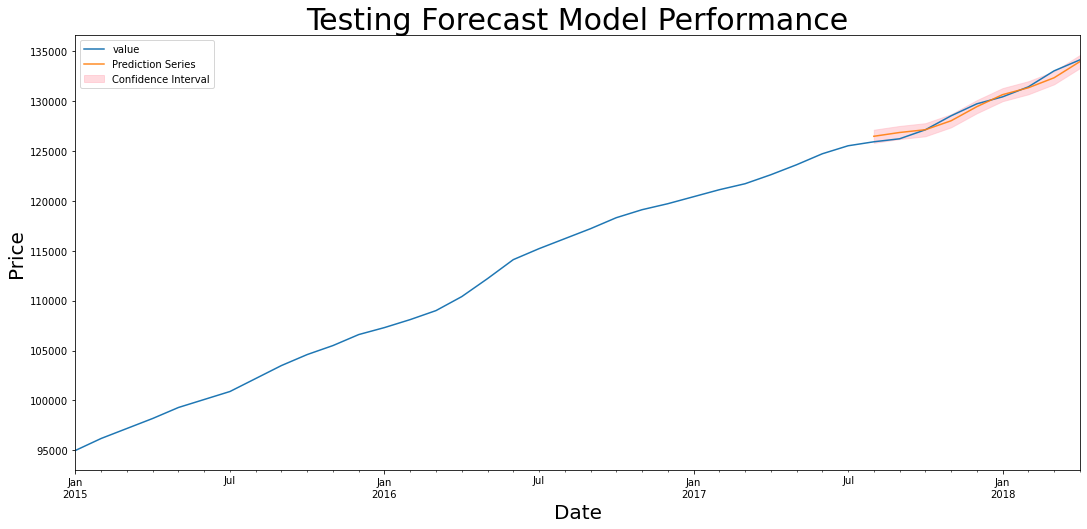

In [99]:
rcParams['figure.figsize'] = 18, 8

# Plot observed values
ax = ts_77015.plot(label='observed')

# Plot predicted values
gpred_77015.predicted_mean.plot(ax=ax, label='Prediction Series', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf_77015.index,
                pred_conf_77015.iloc[:, 0],
                pred_conf_77015.iloc[:, 1], color='lightpink', alpha=0.5,label = 'Confidence Interval')

# Set axes labels
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecast Model Performance',fontsize=30)
plt.legend()

plt.show();

In [100]:
forecast_model_77015 = SARIMAX(ts_77015, order=(1,1,1), seasonal_order=(0, 0, 0, 12))

# Fit the model and print results
full_output_77015 = forecast_model_77015.fit()

print(full_output_77015.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9961      0.005    193.606      0.000       0.986       1.006
ma.L1         -0.9700      0.023    -42.167      0.000      -1.015      -0.925
sigma2      1.108e+05   3.38e-09   3.28e+13      0.000    1.11e+05    1.11e+05


In [101]:
forecast_77015 = full_output_77015.get_forecast(36)
future_prediction_77015 = forecast_77015.conf_int()
future_prediction_77015['value'] = forecast_77015.predicted_mean
future_prediction_77015.columns = ['lower','upper','prediction'] 
future_prediction_77015

,lower,upper,prediction
2018-05-01,134373.901672,135681.251333,135027.576503
2018-06-01,135013.456511,136889.676883,135951.566697
2018-07-01,135706.335886,138037.633009,136871.984448
2018-08-01,136423.633314,139154.053822,137788.843568
2018-09-01,137154.358461,140249.957171,138702.157816
2018-10-01,137892.979945,141330.901851,139611.940898
2018-11-01,138636.275630,142400.137303,140518.206467
2018-12-01,139382.188913,143459.747329,141420.968121
2019-01-01,140129.322021,144511.156796,142320.239409
2019-02-01,140876.680437,145555.387212,143216.033825


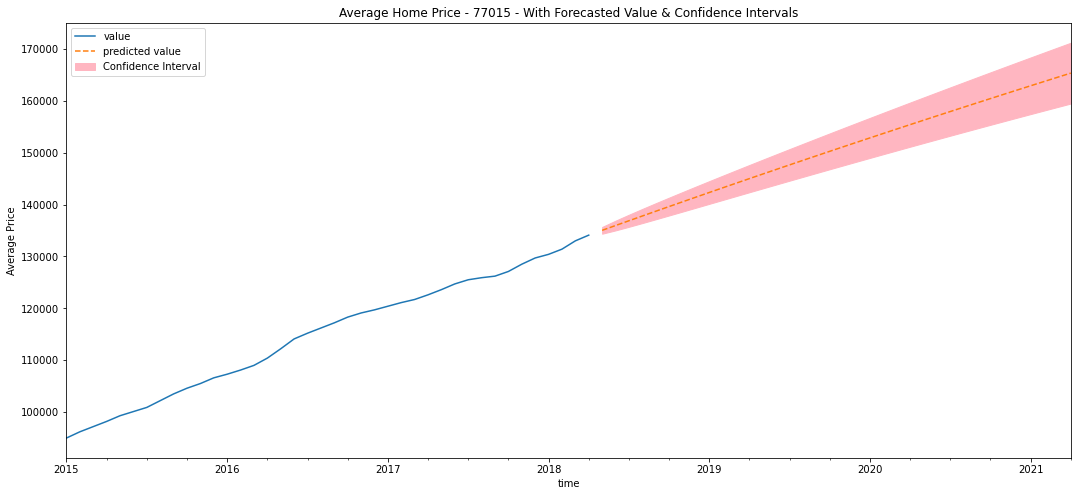

In [102]:
fig, ax = plt.subplots()
ts_77015.plot(ax=ax,label='Real Values')


future_prediction_77015['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction_77015.index, y1= future_prediction_77015['lower'], 
                y2= future_prediction_77015['upper'],color='lightpink',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 77015 - With Forecasted Value & Confidence Intervals')
plt.show()

#### 77099

In [103]:
df_77099 = houston.groupby('Zipcode').get_group(77099)  
df_77099

,Zipcode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1317,77099,72100.0,72100.0,72200.0,72200.0,72200.0,72300.0,72300.0,72300.0,72400.0,...,128500,129100,129500,130300,131100,132100,132400,134000,137400,140100


In [104]:
melted_77099 = melt_data(df_77099)

In [105]:
ts_77099 = melted_77099.sort_index().loc['2015':] 

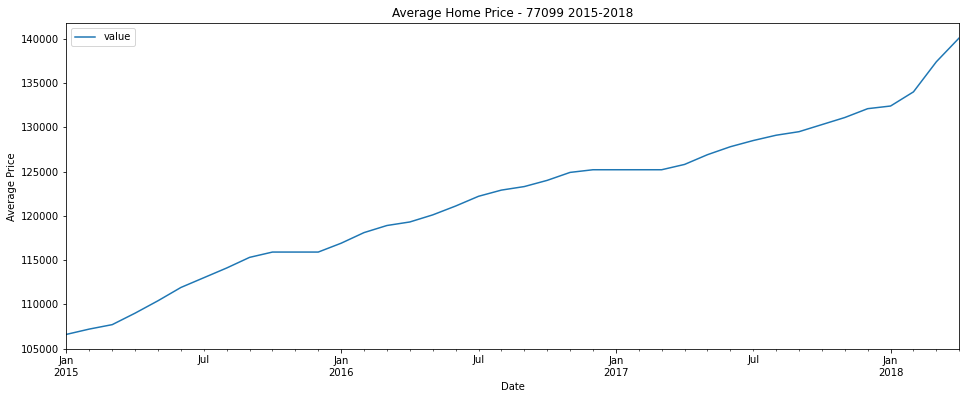

In [106]:
ax = ts_77099.plot(figsize=(16,6)) 
ax.set_ylabel('Home Price') 
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.title('Average Home Price - 77099 2015-2018')
plt.show();

In [107]:
split_77099 = round(ts_77099.shape[0]*0.75)

In [108]:
train_77099 = test_recent[:split_77099]
test_77099 = test_recent[split_77099:]

In [109]:
adfuller(ts_77099)

(0.8707715635171739,
 0.9926967828089001,
 3,
 36,
 {'1%': -3.626651907578875,
  '5%': -2.9459512825788754,
  '10%': -2.6116707716049383},
 445.4978094459082)

In [110]:
best_arima_nostat(ts_77099)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=621.678, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=636.235, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=626.309, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=657.946, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=623.671, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=623.671, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=625.670, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=634.728, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=625.474, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=625.667, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 0.870 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   40
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -309.193
Date:                Tue, 22 Feb 2022   AIC                            624.386
Time:                        09:46:09   BIC                            629.376
Sample:                    01-01-2015   HQIC                           626.176
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.005    221.294      0.000       0.991       1.009
ma.L1         -0.9987      0.091    -10.968      0.000      -1.177      -0.820
sigma2      4.473e+05   1.21e-07   3.71e+12      0.0

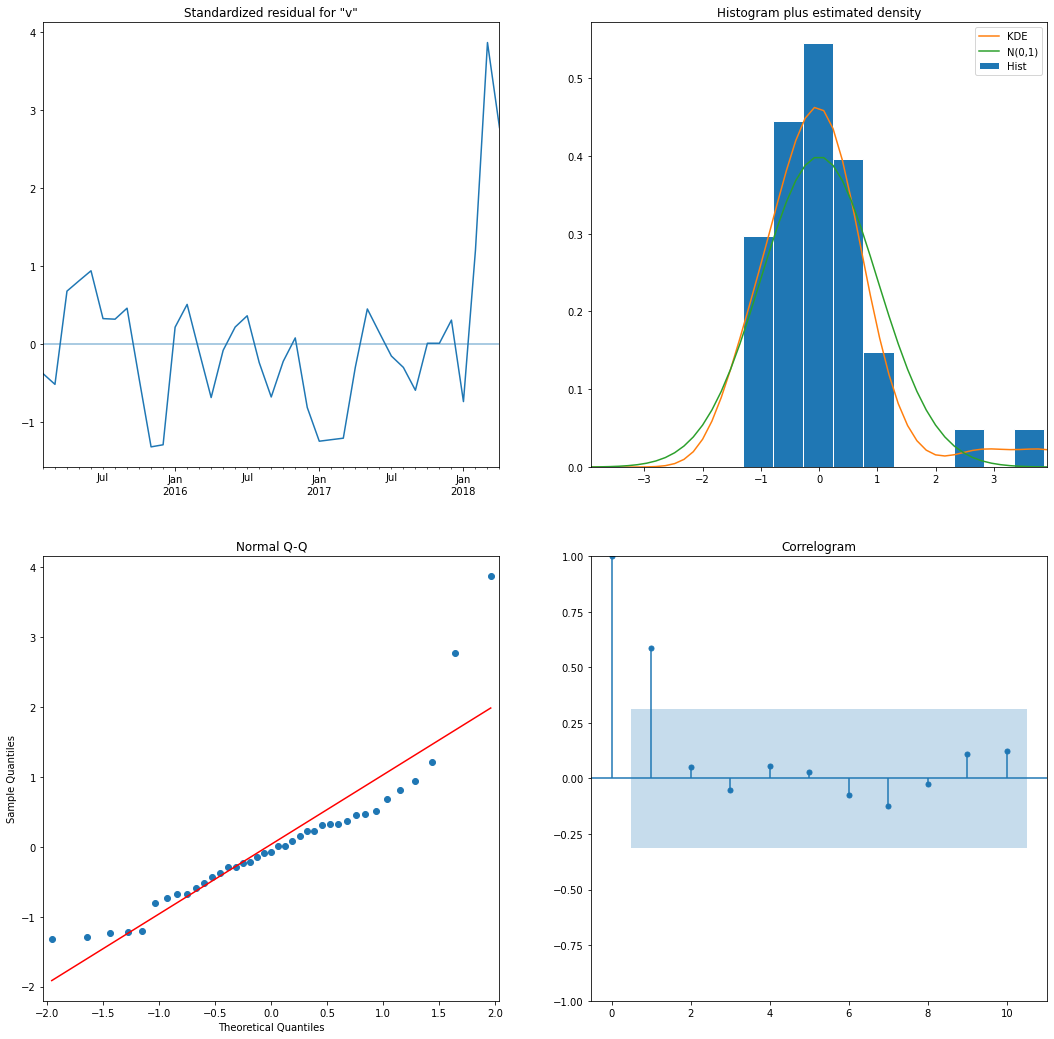

In [111]:
model_77099 = SARIMAX(ts_77099, order=(1,1,1), seasonal_order=(0, 0, 0, 12))

# Fit the model and print results
output_77099 = model_77099.fit()

print(output_77099.summary())
output_77099.plot_diagnostics(figsize=(18,18))
plt.show();

In [112]:
pred_77099 = output_77099.predict(-40)
MAPE = mape(ts_77099,pred_77099)
MAPE

0.028541511185378354

<Figure size 1296x1296 with 0 Axes>

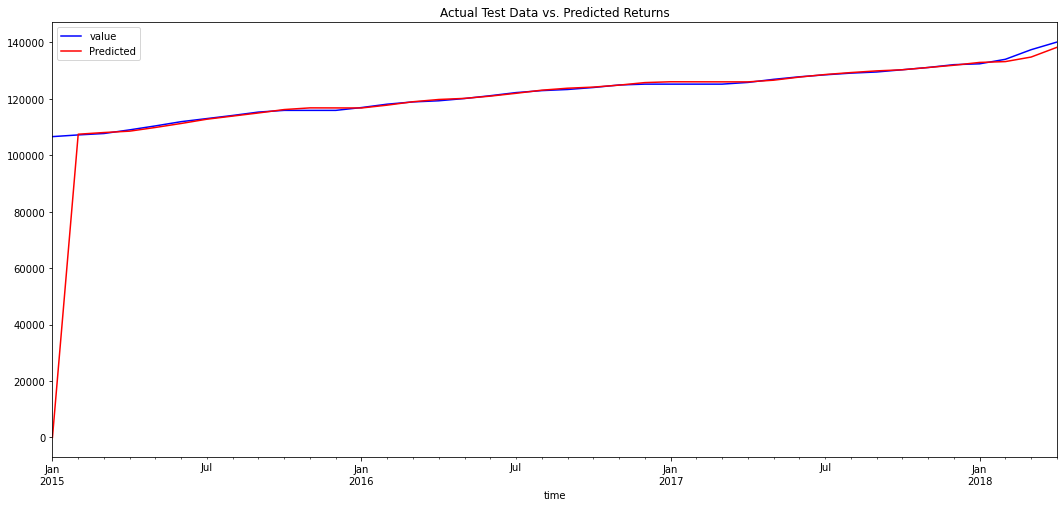

In [113]:
plt.figure(figsize=(18,18))
ts_77099.plot(label='Actual',color='b')
pred_77099.plot(label='Predicted',color='r')
plt.legend(loc='best')
plt.title('Actual Test Data vs. Predicted Returns')
plt.show();

In [114]:
gpred_77099 = output_77099.get_prediction(start=pd.to_datetime('2017-06'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf_77099 = gpred_77099.conf_int()
pred_conf_77099

,lower value,upper value
2017-06-01,126378.550571,129018.169526
2017-07-01,127280.173218,129919.503981
2017-08-01,127978.831136,130617.882101
2017-09-01,128576.089621,131214.868824
2017-10-01,128970.590750,131609.105882
2017-11-01,129770.835490,132409.093926
2017-12-01,130571.073141,133209.081948
2018-01-01,131574.023473,134211.789434
2018-02-01,131867.503326,134505.032950
2018-03-01,133478.365978,136115.665517


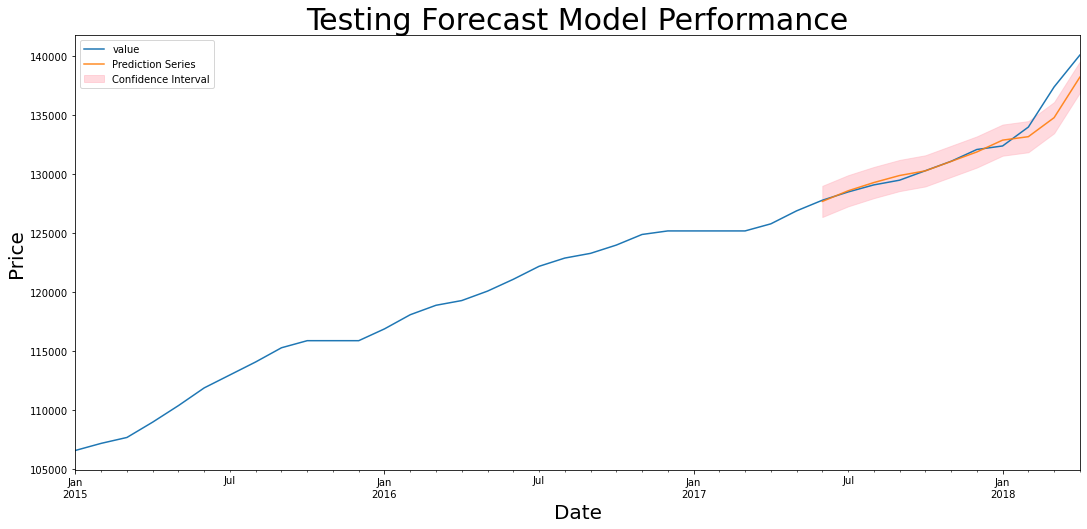

In [115]:
rcParams['figure.figsize'] = 18, 8

# Plot observed values
ax = ts_77099.plot(label='observed')

# Plot predicted values
gpred_77099.predicted_mean.plot(ax=ax, label='Prediction Series', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf_77099.index,
                pred_conf_77099.iloc[:, 0],
                pred_conf_77099.iloc[:, 1], color='lightpink', alpha=0.5,label = 'Confidence Interval')

# Set axes labels
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecast Model Performance',fontsize=30)
plt.legend()

plt.show();

In [116]:
forecast_model_77099 = SARIMAX(ts_77099, order=(1,1,1), seasonal_order=(0, 0, 0, 12))

# Fit the model and print results
full_output_77099 = forecast_model_77099.fit()

print(full_output_77099.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.005    221.294      0.000       0.991       1.009
ma.L1         -0.9987      0.091    -10.968      0.000      -1.177      -0.820
sigma2      4.473e+05   1.21e-07   3.71e+12      0.000    4.47e+05    4.47e+05


In [117]:
forecast_77099 = full_output_77099.get_forecast(36)
future_prediction_77099 = forecast_77099.conf_int()
future_prediction_77099['value'] = forecast_77099.predicted_mean
future_prediction_77099.columns = ['lower','upper','prediction'] 
future_prediction_77099

,lower,upper,prediction
2018-05-01,139636.655669,142273.512832,140955.084250
2018-06-01,139933.765449,143686.516368,141810.140908
2018-07-01,140352.683366,144977.656584,142665.169975
2018-08-01,140833.410617,146206.932285,143520.171451
2018-09-01,141352.885464,147397.405212,144375.145338
2018-10-01,141899.369684,148560.813588,145230.091636
2018-11-01,142465.943174,149704.077518,146085.010346
2018-12-01,143048.131734,150831.671204,146939.901469
2019-01-01,143642.851756,151946.678256,147794.765006
2019-02-01,144247.875774,153051.326142,148649.600958


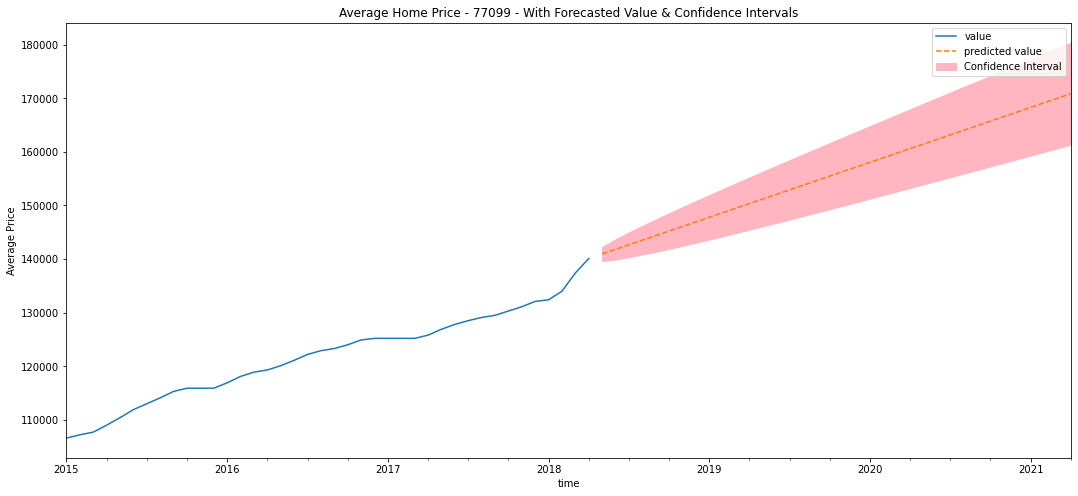

In [118]:
fig, ax = plt.subplots()
ts_77099.plot(ax=ax,label='Real Values')


future_prediction_77099['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction_77099.index, y1= future_prediction_77099['lower'], 
                y2= future_prediction_77099['upper'],color='lightpink',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 77099 - With Forecasted Value & Confidence Intervals')
plt.show()